In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import tqdm as tqdm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/train.csv', encoding = 'cp949')
test = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/test.csv',encoding = 'cp949')
submission = pd.read_csv('/content/drive/MyDrive/데이콘/전력사용량 예측/sample_submission.csv', encoding = 'cp949')

In [ ]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [ ]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 결측치 확인하기
print('train 결측치', '\n' ,train.isnull().sum())
print('test 결측치', '\n', test.isnull().sum())

train 결측치 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64
test 결측치 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


- test에 엄청 많은 결측치가 포함되어있다.

In [ ]:
# 데이터 타입확인하기
print('train.shape',train.shape)
print('test.shape', test.shape)

train.shape (122400, 10)
test.shape (10080, 9)


## 종속변수 확인해보기

In [ ]:
# 전력사용량(kWh)로 표시해주기 너무 불편함으로 target이라고 바꿔주자.
train=train.rename(columns = {'전력사용량(kWh)': 'target'})

test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [ ]:
train['log_target'] = train['target'].apply(lambda x: np.log1p(x))

Text(0.5, 1.0, 'boxenplot of target')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


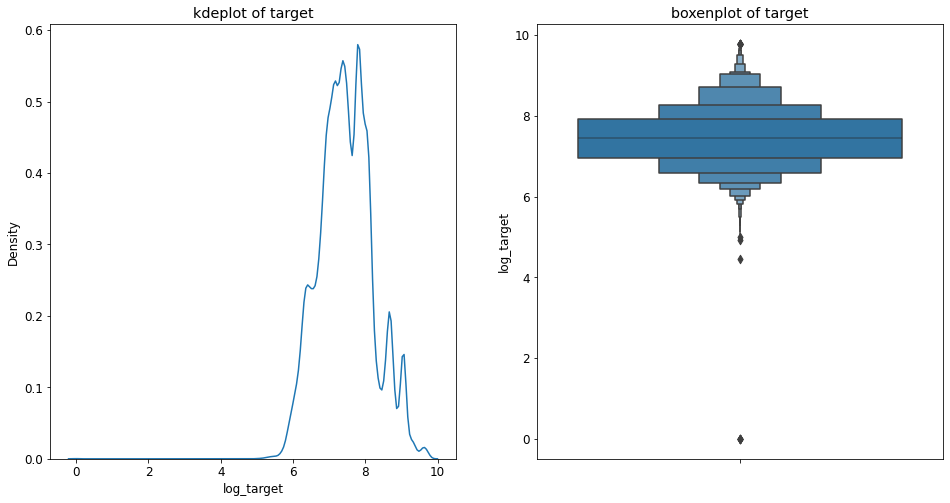

In [ ]:
# 정규화가 되어있지 않고 1000~2500까지 많은데이터가 분포되어잇다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(data = train, x = 'log_target', ax = ax[0])
ax[0].set_title('kdeplot of target')

sns.boxenplot(data = train, y = 'log_target', ax = ax[1])
ax[1].set_title('boxenplot of target')

- 이상치가 많은것으로 보여진다.

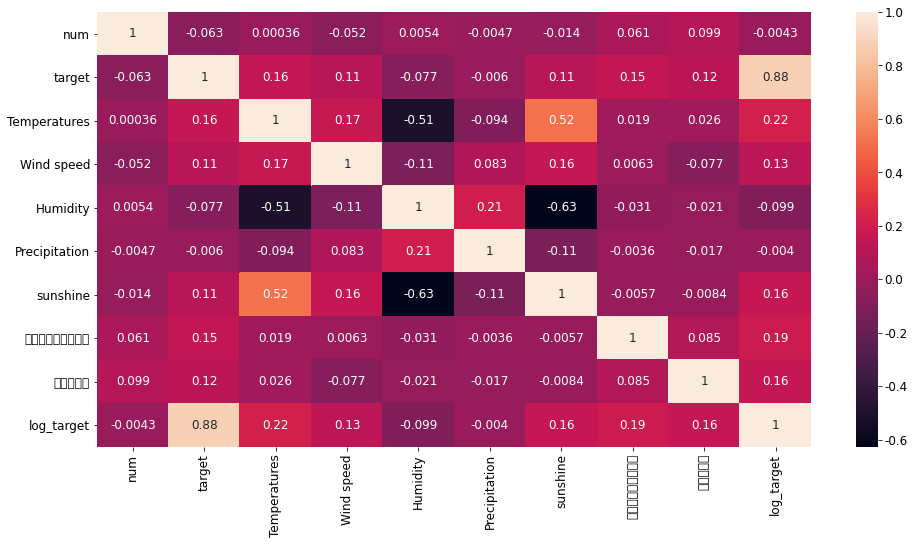

In [ ]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
train=train.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm)':'Precipitation','일조(hr)':'sunshine'})

train_corr=train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

### test의 결측값이 결측값이 아닌것을 확인했고 우리는 interpolate를 사용하여 채워주자.

In [ ]:
# 결측치 채우기
col = ['Temperatures','Wind speed','Humidity','Precipitation','sunshine']
for i in col:
    test[i] = test[i].interpolate()

In [ ]:
test

,num,date_time,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,NaN,NaN
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,NaN,NaN
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,NaN,NaN
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,NaN,NaN
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,NaN,NaN
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,NaN,NaN
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,NaN,NaN


## num(한 건물을 나타낸다.)

In [ ]:
train.num.unique()
# 60개의 건물이 있다는 것을 확인했다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

- 각 건물마다 전기 사용량이 제각각 다른 것을 확인했다.

## date_time

In [ ]:
# 월, 일, 시간 별로 나누는 함수 만들기
def date_time(df, columns = 'date_time'):
    df['month'] = df[columns].apply(lambda x: x[5:7])
    df['day'] = df[columns].apply(lambda x:x[8:10])
    df['hour'] = df[columns].apply(lambda x:x[11:])
    return df
# train데이터에 적용시켜주기
train = date_time(train)
test = date_time(test)

In [ ]:
# 평일과 공휴일 함수 만들기
def weekday(df, columns = 'date_time'):
    df[columns]=pd.to_datetime(df[columns])
    df['weekday'] = df[columns].apply(lambda x:x.weekday())
    df['weekday'] = df['weekday'].apply(lambda x:1 if x >4 else 0)
    return df
# 평일과 공휴일 함수 적용시켜주기
train=weekday(df = train)
test = weekday(df = test)

### 월별 데이터 확인해보기

Text(0.5, 1.0, 'boxnplot - month of target')

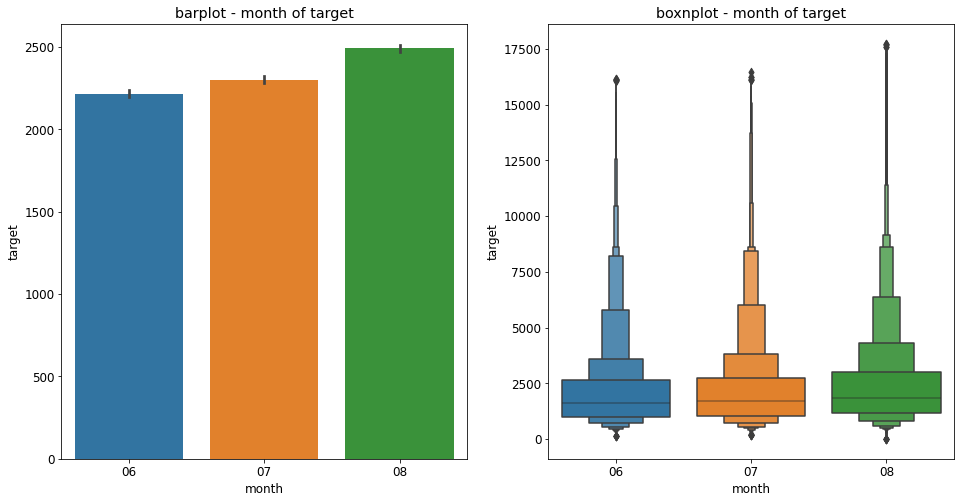

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('barplot - month of target')

sns.boxenplot(data = train, x= 'month', y = 'target', ax = ax[1])
ax[1].set_title('boxnplot - month of target')

- 시간이 지날수록 더 많은 전력량을 사용하는 것을 알 수 있다.
- 우리는 test값이 8월달의 데이터만 가지고 있기 때문에 어떻게 분석해줄지는 확인해 봐야겠다.

### 일별 확인해 보기

Text(0.5, 1.0, 'boxenplot - day of target')

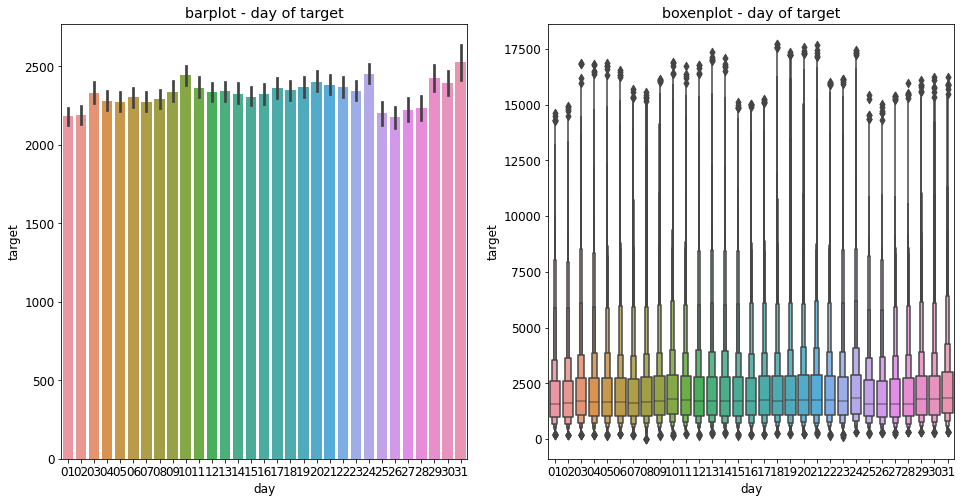

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', ax = ax[0])
ax[0].set_title('barplot - day of target')

sns.boxenplot(data = train, x = 'day', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - day of target')

- 일별로 큰 차이가 있다고 말 할수는 없을 것 같다

### 시간별 확인해 보기

Text(0.5, 1.0, 'boxenplot - hour of target')

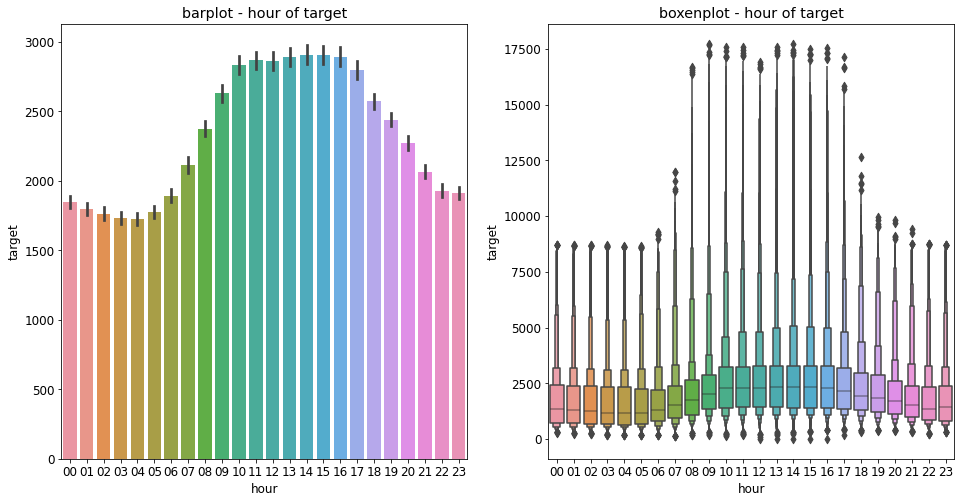

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', ax = ax[0])
ax[0].set_title('barplot - hour of target')

sns.boxenplot(data = train, x = 'hour', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - hour of target')

- 시간별로 확실한 차이가 있다고 말할 수 있다.
- 사람들이 활동하는 시간에 전력소모량이 가장 많은 것을 알 수 있다.

### 평일과 주말로 비교해보기

Text(0.5, 1.0, 'boxenplot of weekday')

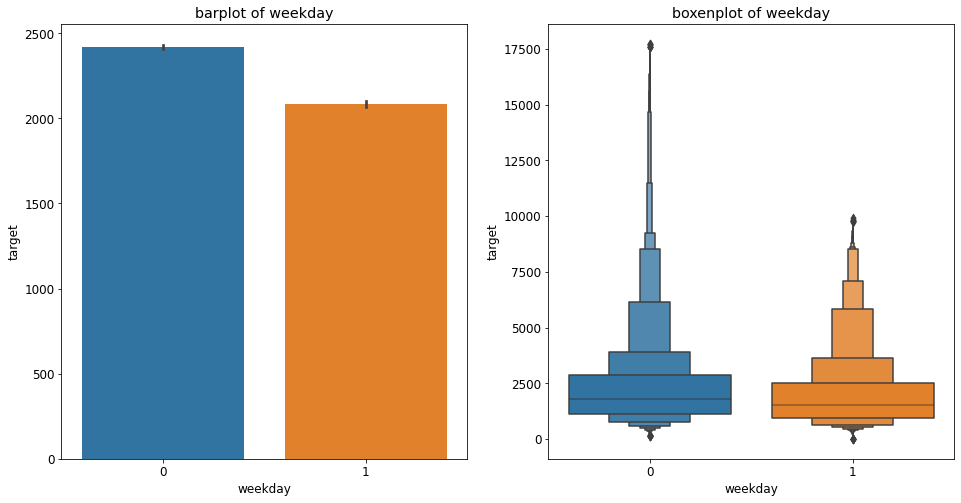

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('barplot of weekday')

sns.boxenplot(data = train, x = 'weekday', y  ='target', ax = ax[1])
ax[1].set_title('boxenplot of weekday')

- 평일에 많은 전력량을 소모하는 것으로 나타낸다.

Text(0.5, 1.0, 'weekday month target')

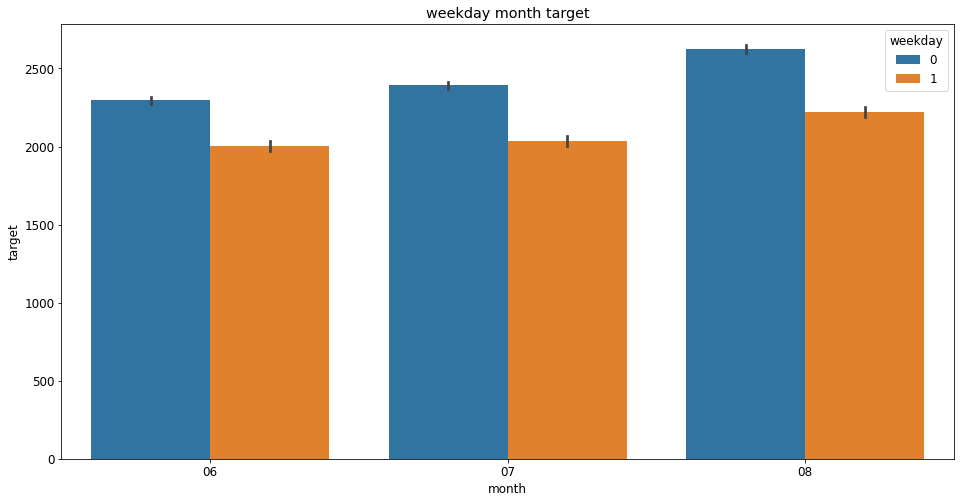

In [ ]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', hue = 'weekday')
plt.title('weekday month target')

Text(0.5, 1.0, 'weekday day target')

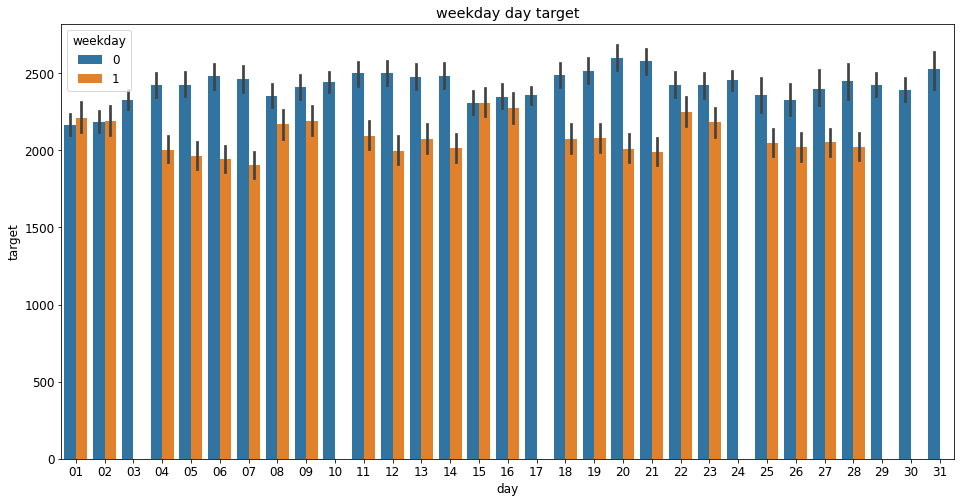

In [ ]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', hue = 'weekday')
plt.title('weekday day target')

- 주말이 없는 날짜가 있기 때문에 표시가 안된 부분도 있다.

Text(0.5, 1.0, 'weekday hour target')

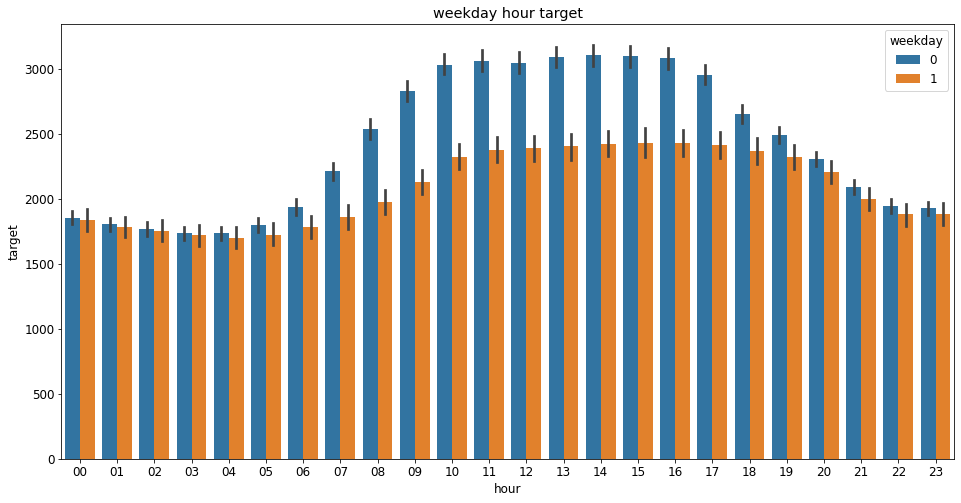

In [ ]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')
plt.title('weekday hour target')

In [ ]:
train['hour'] = train['hour'].astype('int')
test['hour'] = test['hour'].astype('int')
# 일하는 시간과 일하지 않는 시간 구분해주기
train.loc[ <train['hour']]

## 기온(Temperatures)

In [ ]:
# min = 11.1, max = 36.3
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

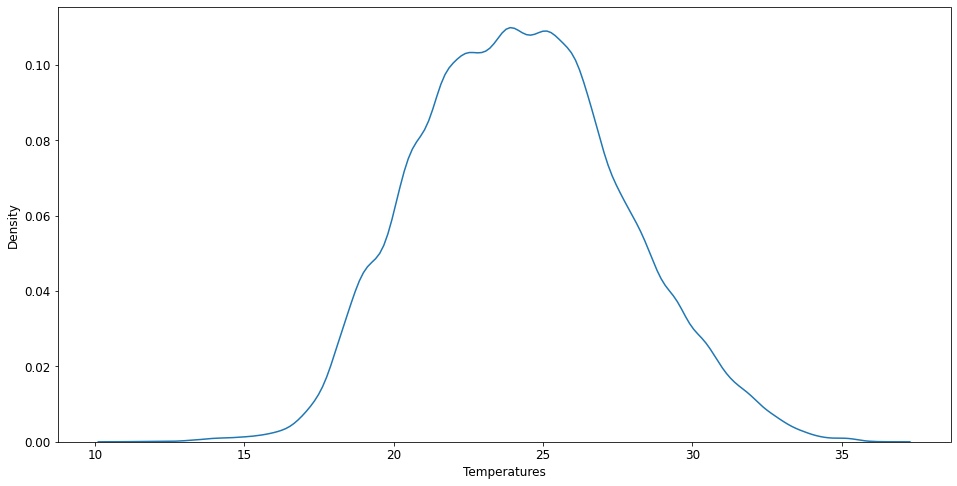

In [ ]:
sns.kdeplot(data = train, x = 'Temperatures')

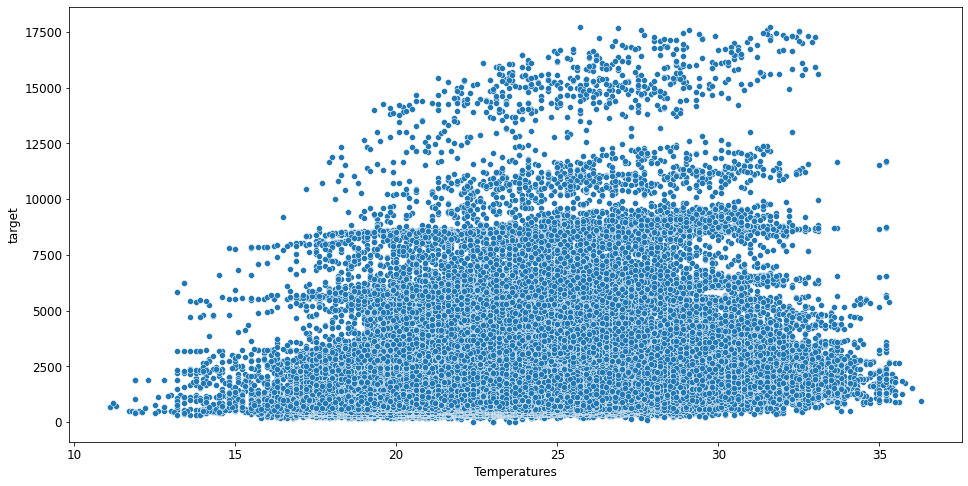

In [ ]:
sns.scatterplot(data = train, x = 'Temperatures', y = 'target')

In [ ]:
# 이 데이터는 온도에 따라 나눠주는 것이기 때문에 train의 데이터롤 그대로 가지고 와야한다.
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

In [ ]:
# 데이터를 나눠주는 것이 의미가 있다고 판단되지 않는다.
# train.loc[21.800000 >= train['Temperatures'], 'temperature_binning'] = 0
# train.loc[(21.800000 < train['Temperatures']) & (train['Temperatures'] < 24.200000), 'temperature_binning'] = 1
# train.loc[(24.200000 < train['Temperatures']) & (train['Temperatures'] < 26.500000), 'temperature_binning'] = 2
# train.loc[(26.500000 < train['Temperatures']), 'temperature_binning'] = 3

# test.loc[21.800000 >= test['Temperatures'], 'temperature_binning'] = 0
# test.loc[(21.800000 < test['Temperatures']) & (test['Temperatures'] < 24.200000), 'temperature_binning'] = 1
# test.loc[(24.200000 < test['Temperatures']) & (test['Temperatures'] < 26.500000), 'temperature_binning'] = 2
# test.loc[(26.500000 < test['Temperatures']), 'temperature_binning'] = 3

In [ ]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.barplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[0])
# ax[0].set_title('temperature_binning barplot')

# sns.boxenplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[1])
# ax[1].set_title('temperature_binning boxenplot')

- 이상치가 많은것으로 보이고 이상치는 사용 용도인 num에 따라서 다른 것 같다 우리는 num을 target 별로 군집화 하는게 어떨지 생각해 본다.
- 그게 안된다면 target을 포함한 변수들로 건물의 쓰이는 용도를 군집화 해주는 방법도 좋은 것 같다.

## 풍향(Wind speed)

In [ ]:
train['Wind speed'].value_counts()

1.1     4241
1.6     3911
1.5     3831
1.2     3811
1.4     3746
        ... 
16.3       1
16.8       1
11.9       1
15.4       1
16.6       1
Name: Wind speed, Length: 155, dtype: int64

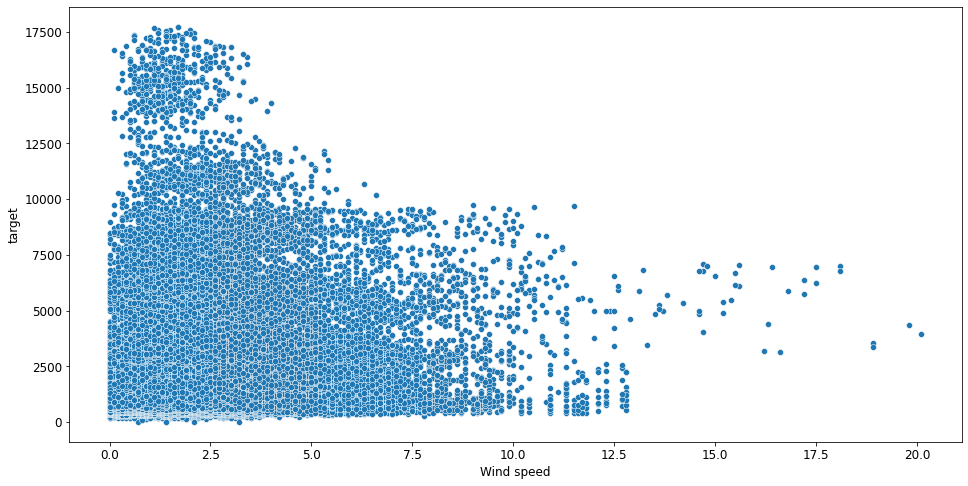

In [ ]:
sns.scatterplot(data =train, x = 'Wind speed', y = 'target')

## 습도(Humidity)

In [ ]:
train['Humidity'].value_counts

<bound method IndexOpsMixin.value_counts of 0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64>

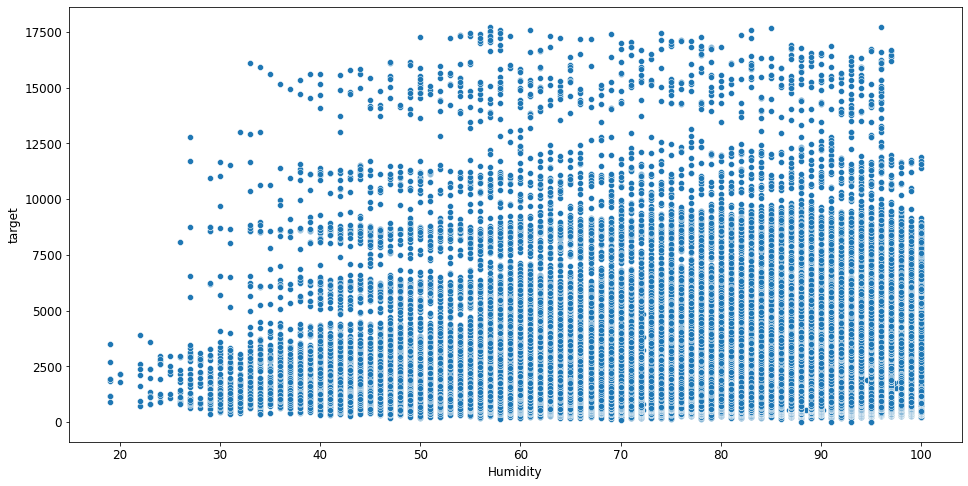

In [ ]:
sns.scatterplot(data = train, x = 'Humidity', y = 'target')

## 강수량(Precipitation)

In [ ]:
train['Precipitation'].value_counts()

0.0     103473
0.1       2508
0.2       1644
0.3       1171
0.5        830
         ...  
25.1         1
25.2         1
27.9         1
31.0         1
54.6         1
Name: Precipitation, Length: 296, dtype: int64

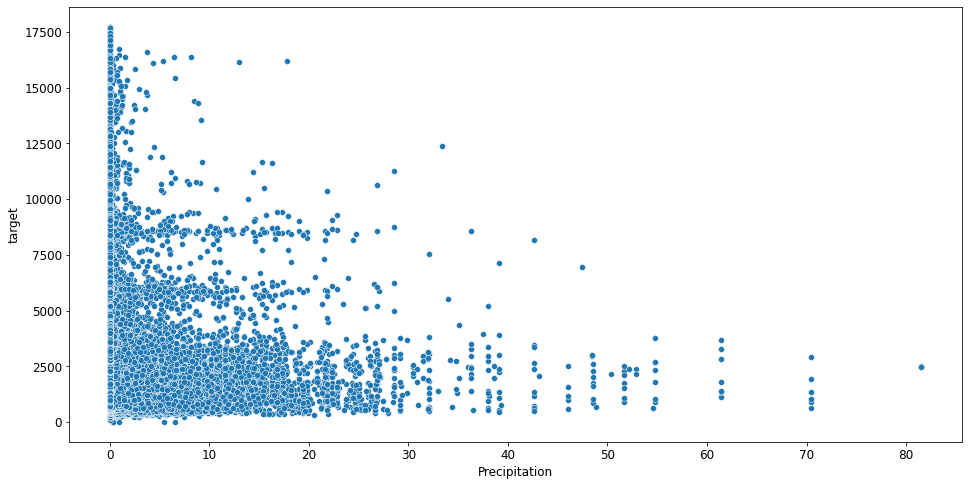

In [ ]:
sns.scatterplot(data = train, x = 'Precipitation', y = 'target')

In [ ]:
train['Precipitation_binning']= train['Precipitation'].apply(lambda x:1 if x >0 else 0)

In [ ]:
# 관련이 없다고 판단되어 지워주도록 하자.
train = train.drop('Precipitation_binning', axis = 1)

## 일조(sunshine)

In [ ]:
train['sunshine'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: sunshine, dtype: int64

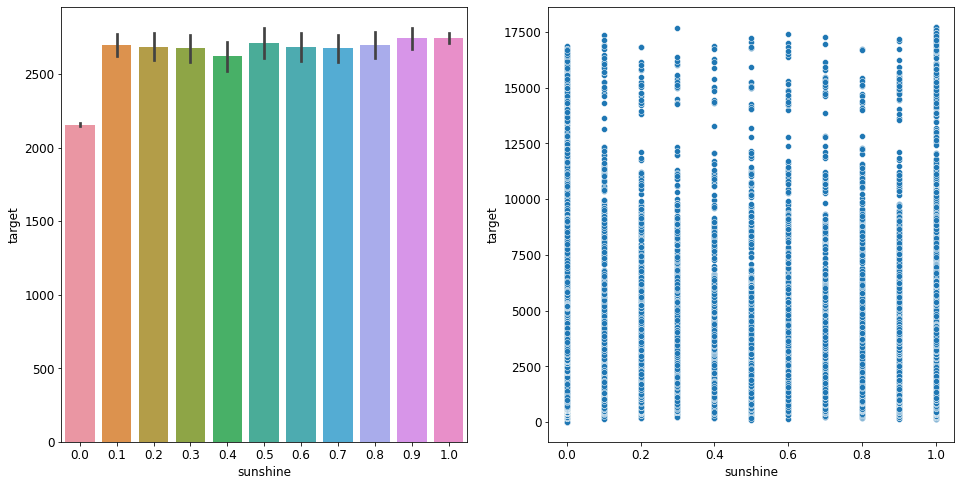

In [ ]:
fig, ax = plt.subplots(ncols = 2)
sns.barplot(data = train, x = 'sunshine', y = 'target', ax = ax[0])

sns.scatterplot(data = train, x = 'sunshine', y = 'target', ax = ax[1])

## 비전기냉방설비운영

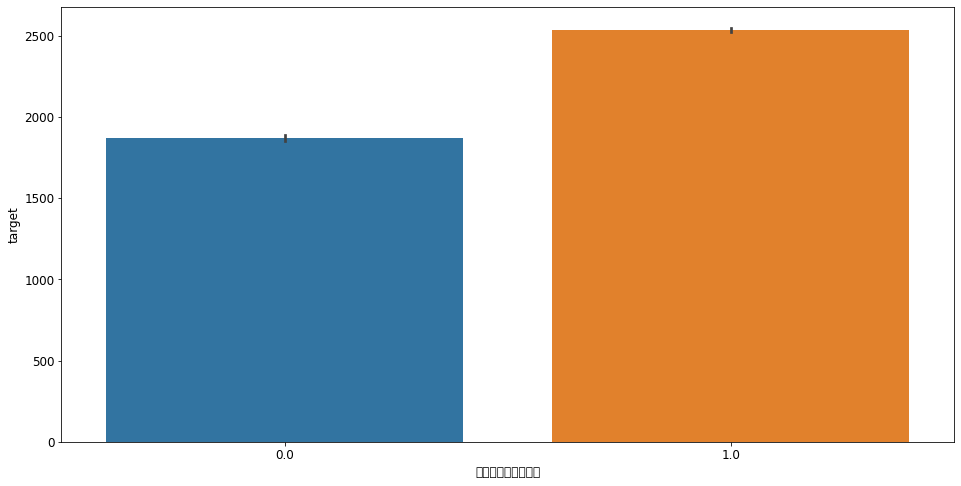

In [ ]:
sns.barplot(data = train, x = '비전기냉방설비운영', y = 'target')

In [ ]:
# 비전기냉방설비운영을 안하고있다가 하고 있는 곳을 확인했지만 그런 곳은 확인하지 못했다.
비전기냉방설비운영_0=list(train[train['비전기냉방설비운영'] == 0]['num'].unique())
비전기냉방설비운영_1=list(train[train['비전기냉방설비운영'] == 1]['num'].unique())

for i in 비전기냉방설비운영_0:
    비전기냉방설비운영_1.append(i)


len(비전기냉방설비운영_1) == len(train['num'].unique())

True

## 태양광보유

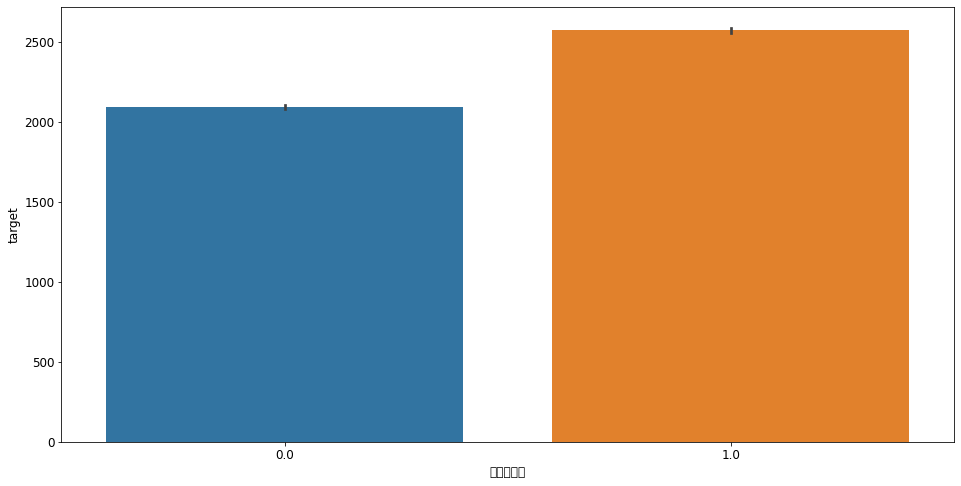

In [ ]:
sns.barplot(data = train, x = '태양광보유', y = 'target')

In [ ]:
# 태양광을 보유하지 않다가 보유한 건물이 있는지 확인해 보자.
태양광보유_0 = list(train[train['태양광보유'] == 0]['num'].unique())
태양광보유_1 = list(train[train['태양광보유'] == 1]['num'].unique())

for i in 태양광보유_0:
    태양광보유_1.append(i)
    
len(태양광보유_1) == len(train['num'].unique())

True

In [ ]:
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 0), 'new_column'] = 0
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 1), 'new_column'] = 1
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 0), 'new_column'] = 2
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 1), 'new_column'] = 3

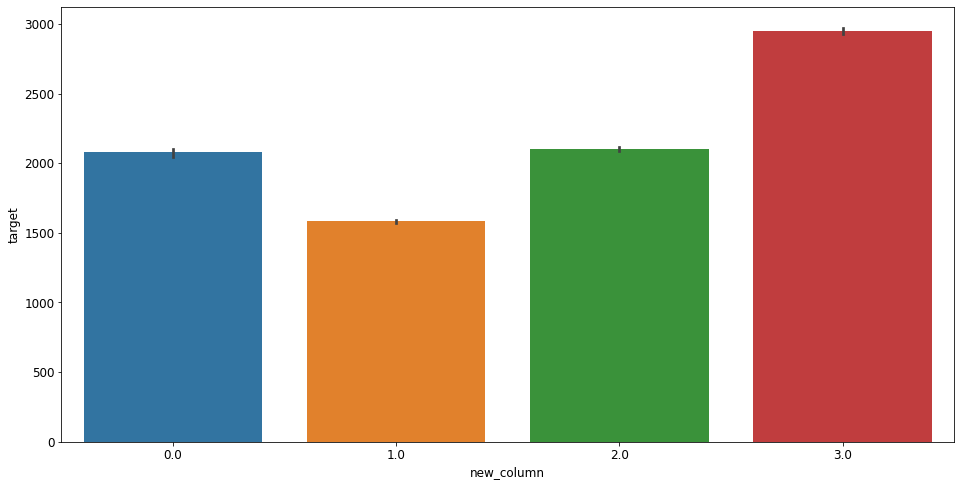

In [ ]:
sns.barplot(data = train, x = 'new_column', y = 'target')

## 체감온도 구하기

In [ ]:
def summer_temperature1(df = None):
  b = df['Humidity']

  T = df['Temperatures'].apply(lambda x: 32 + (1.8 * x))

  temperature = -42.379 + (2.04901523*T) + (10.14333127 * b ) - (0.22475541 * T * b) - (0.00683783 * (T ** 2)) - (0.05481717 * (b**2)) + (0.00122874 * (T**2) * b ) + (0.00085282 *  T * (b ** 2)) - (0.00000199 * (T **2) * (b ** 2))

  return temperature


train['열지수'] = summer_temperature1(train)
test['열지수']= summer_temperature1(test)

# 정규화를 진행해 주면 점수가 올라간다.
# train['열지수'] = train['열지수'].apply(lambda x:np.log1p(x))
# test['열지수'] = test['열지수'].apply(lambda x:np.log1p(x))

# 데이터를 주의, 매우 주의, 위험, 매우위험 으로 나누어서 확인해보기
# train['열지수'] = pd.cut(train['열지수'], bins = [0,90,103,124,150], labels = [0,1,2,3])
# test['열지수'] = pd.cut(test['열지수'], bins = [0,90,103,124,150], labels = [0,1,2,3])

In [ ]:
# 열지수 공식이 잘못되어 있고 열지수를 구할 때 binning을 해주어야 한다.
# def summer_temperature(df = None): 
#     def tem1(x):
#         T = 'Temperatures'
#         H = 'Humidity'
#         temperature = x[T] + ((x[H] - 50)* 0.1)
#         return temperature
#     temperature = tem1(df)
#     df['여름철 체감온도'] = temperature
    
#     return df

In [ ]:
# train= winter_temperature(train)
# test = winter_temperature(test)
                                      
# train = summer_temperature(train)
# test = summer_temperature(test)

습도 50%를 기준으로 10%가 올라가면 플러스 1도, 떨어지면 마이너스 1도로 치고 폭염주의보와 경보도 기온이 아니라 체감온도를 기준으로 발령하기로 했습니다 

In [ ]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.scatterplot(data = train, x = '겨울철 체감온도', y = 'target', ax = ax[0])
# ax[0].set_title('winter temperature')

# sns.scatterplot(data = train, x = '여름철 체감온도', y = 'target')
# plt.title('summer temperature')

## 불쾌지수 구하기

![%EC%BA%A1%EC%B2%98.PNG](attachment:%EC%BA%A1%EC%B2%98.PNG)

In [ ]:
def 불쾌지수구하기(df = None):
    def 불쾌지수구하기(x):
        T = 'Temperatures'
        H = 'Humidity'
        불쾌지수 = (9/5 * x[T]) - (0.55 * (1 - x[H]/100) * ((9 / 5 * x[T]) - 26)) + 32
        
        return 불쾌지수
    불쾌지수  = 불쾌지수구하기(df)
    df['불쾌지수'] = 불쾌지수
    
    return df

train=불쾌지수구하기(train)
test = 불쾌지수구하기(test)

In [ ]:
# 더미화를 시키면 test데이터의 경우 0번의 데이터가 없으므로 더미화는 시켜주지 않기로 한다.
train['불쾌지수'] = pd.cut(train['불쾌지수'], bins = [0,68,75,80,200], labels = [0,1,2,3])
test['불쾌지수'] = pd.cut(test['불쾌지수'], bins = [0,68,75,80,200], labels = [0,1,2,3])

In [ ]:
# 대부분의 데이터가 불쾌지수가 올라 갈수록 높은 전력사용량을 갖고 있다.
for i in train['num'].unique():
  sns.scatterplot(data = train[train['num'] == i], x = '불쾌지수', y = 'target')
  plt.title(f'{i}')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Test EDA

In [ ]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [ ]:
test.isnull().sum()

num                 0
date_time           0
Temperatures        0
Wind speed          0
Humidity            0
Precipitation       0
sunshine            0
비전기냉방설비운영        7784
태양광보유            8456
month               0
day                 0
hour                0
weekday             0
working             0
열지수                 0
불쾌지수                0
dtype: int64

In [ ]:
print('3시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Temperatures']) - (len(test['Temperatures'])/3))
print('6시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Humidity']) - len(test['Humidity'])/ 6)
# 해당 결측치의 값과 같다.

3시간마다 데이터가 입력된다면 결측치의 값 : 6720.0
6시간마다 데이터가 입력된다면 결측치의 값 : 8400.0


- 기온, 풍속, 습도. 일조는 3시간마다 데이터가 입력되어 있다.
- 그러나 강수량은 6시간마다 데이터가 입력되어 있기 때문에 결측치도 다르다.
- 그래서 이 데이터를 어떻게 해주어야 할지 고민해 봐야겠다.

In [ ]:
# Nan값으로 표시된 것은 전부 비전기냉방설비운영을 하지않는 사람인 것 같다.
test['비전기냉방설비운영'].value_counts()

1.0    2296
Name: 비전기냉방설비운영, dtype: int64

In [ ]:
# Nan값으로 표시된 것은 전부 태양광보유를 하지 않은 사람이다.
test['태양광보유'].value_counts()

1.0    1624
Name: 태양광보유, dtype: int64

In [ ]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 비전기냉방설비운영
for num in test['num'].unique():
    if len(test[test['num'] == num]['비전기냉방설비운영'].value_counts()) == 1:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 1
    else:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 0

In [ ]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 태양광보유
for num in test['num'].unique():
    if len(test[test['num'] == num]['태양광보유'].value_counts()) == 1:
        test.loc[test['num'] == num, '태양광보유'] = 1
    else:
        test.loc[test['num'] == num, '태양광보유'] = 0

In [ ]:
print(test['비전기냉방설비운영'].value_counts())
print(test['태양광보유'].value_counts())

1.0    6888
0.0    3192
Name: 비전기냉방설비운영, dtype: int64
0.0    5208
1.0    4872
Name: 태양광보유, dtype: int64


In [ ]:
len(test)

10080

In [ ]:
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 0), 'new_column'] = 0
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 1), 'new_column'] = 1
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 0), 'new_column'] = 2
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 1), 'new_column'] = 3

In [ ]:
# 냉방도일
def CDH(xs):
  ys = []
  for i in range(len(xs)):
    if i < 11:
      ys.append(np.sum(xs[:(i+1)]-26))
    else:
      ys.append(np.sum(xs[(i-11):(i+1)]-26))
  return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
  temp = train[train['num'] == num]
  cdh = CDH(temp['Temperatures'].values)
  cdhs = np.concatenate([cdhs,cdh])

train['냉방도일'] = cdhs

cdhs = np.array([])
for num in range(1,61,1):
  temp = test[test['num'] == num]
  cdh = CDH(temp['Temperatures'].values)
  cdhs = np.concatenate([cdhs,cdh])
  
test['냉방도일'] = cdhs

In [ ]:
# 냉방도일은 정규화를 하려고 했지만 누적으로 쌓인 냉방도일에 정규화를 시켜주면 모델에 안좋은 영향이 있다고 판단하기 때문에
# 정규화를 시켜주지 않도록 한다.
# train.냉방도일.min()

In [ ]:
# 점수가 내려가는 관계로 이건 없애는 걸로 하자.
# train['냉방도일'] = train['냉방도일'].apply(lambda x:x + 151.3)
# test['냉방도일'] = test['냉방도일'].apply(lambda x:x + 151.3)

# train['냉방도일'] = train['냉방도일'].apply(lambda x:np.log1p(x))
# test['냉방도일'] = test['냉방도일'].apply(lambda x:np.log1p(x))

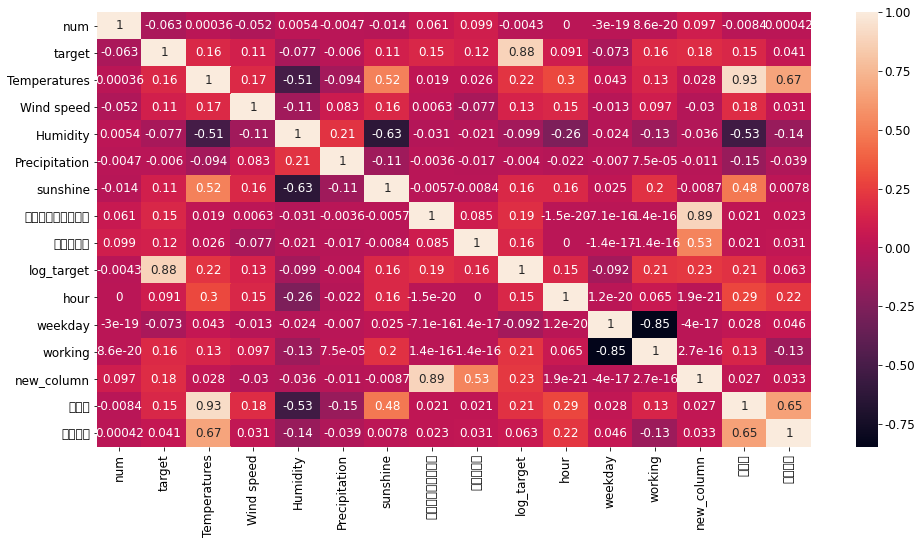

In [ ]:
# 건물마다 특성이 다르기 때문에 상관성이 안좋게 나온다.
train_corr = train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

In [ ]:
# Humidity도 해주려고 했지만 연관성이 없어서 배제하기로 했다.

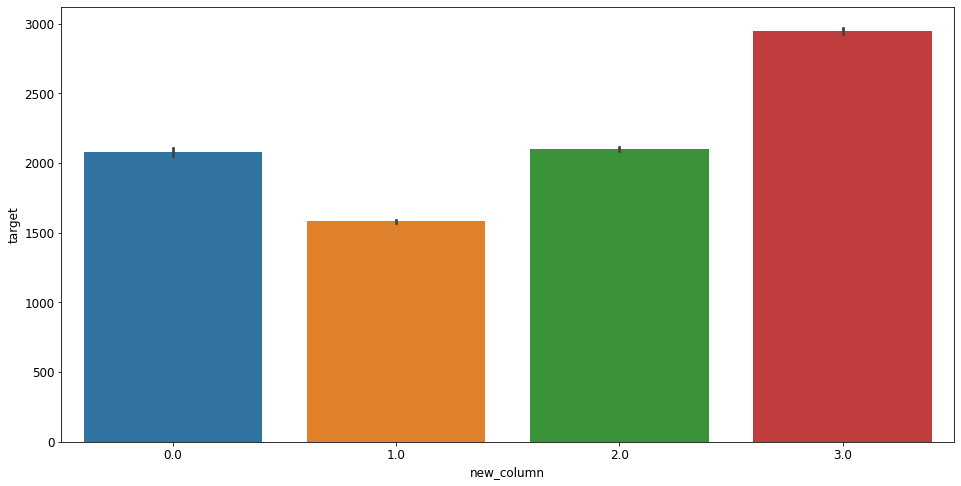

In [ ]:
sns.barplot(data = train, x = 'new_column', y = 'target')

In [ ]:
train.columns


0         -8.4
1        -16.7
2        -25.2
3        -34.1
4        -43.1
          ... 
122395    30.8
122396    32.3
122397    32.5
122398    31.3
122399    29.2
Name: 냉방도일, Length: 122400, dtype: float64


In [ ]:
for i in train['num'].unique():
  sns.scatterplot(data = train[train['num'] == i], x = '냉방도일', y = 'target', hue = 'weekday')
  plt.title(f'{i}')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

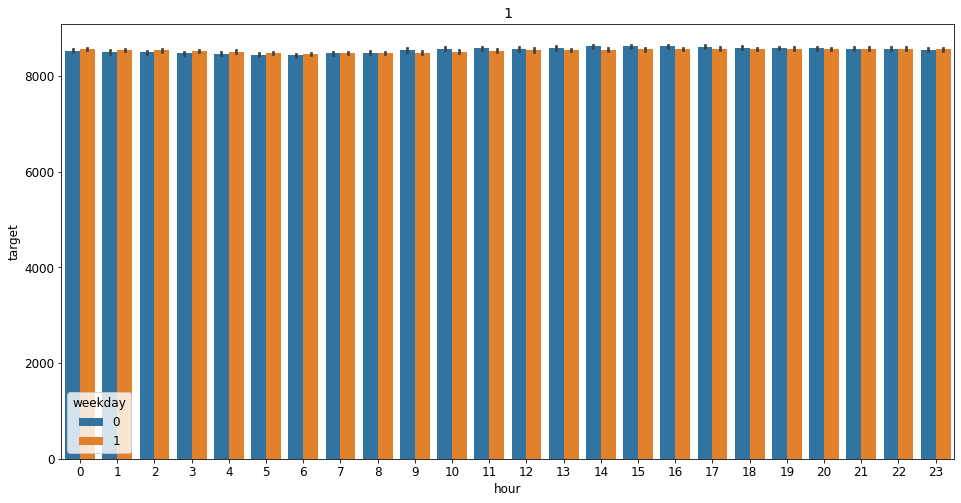

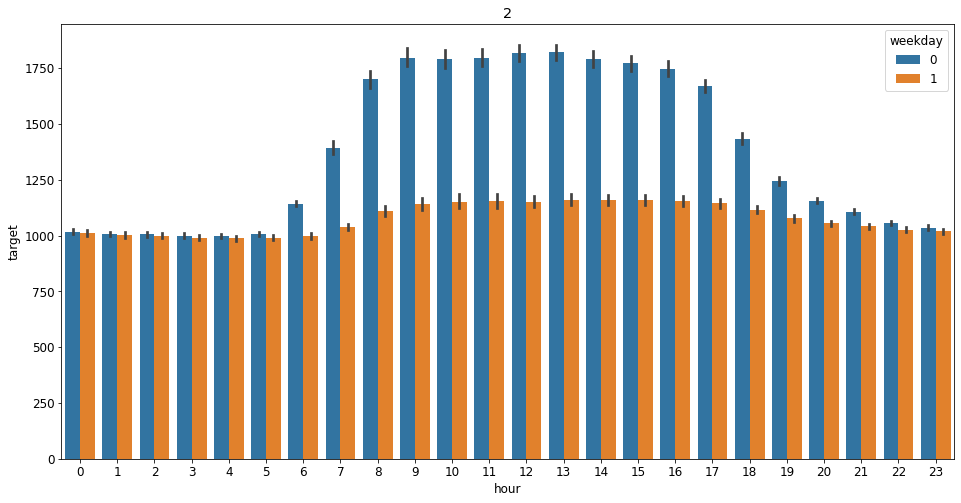

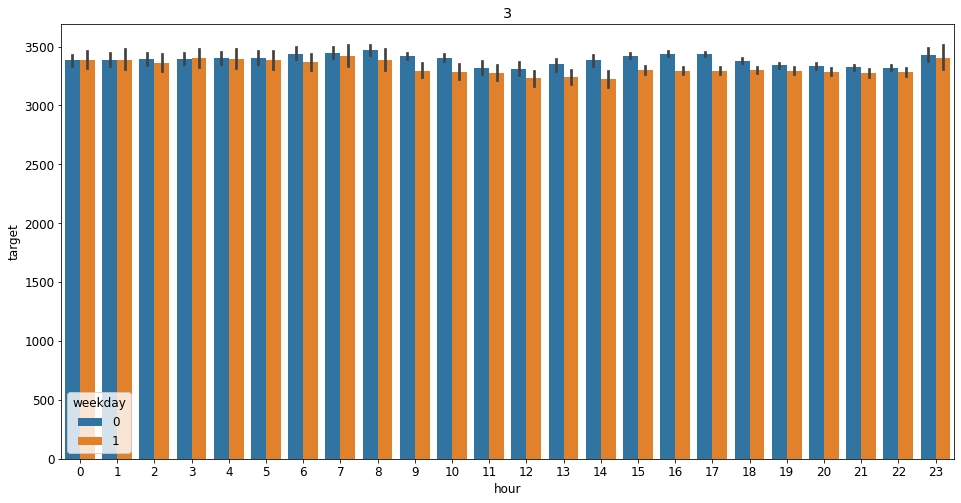

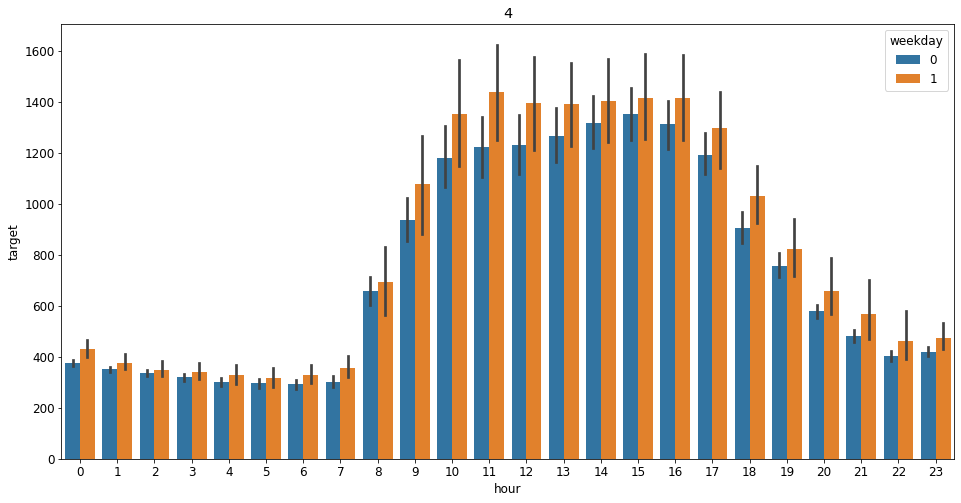

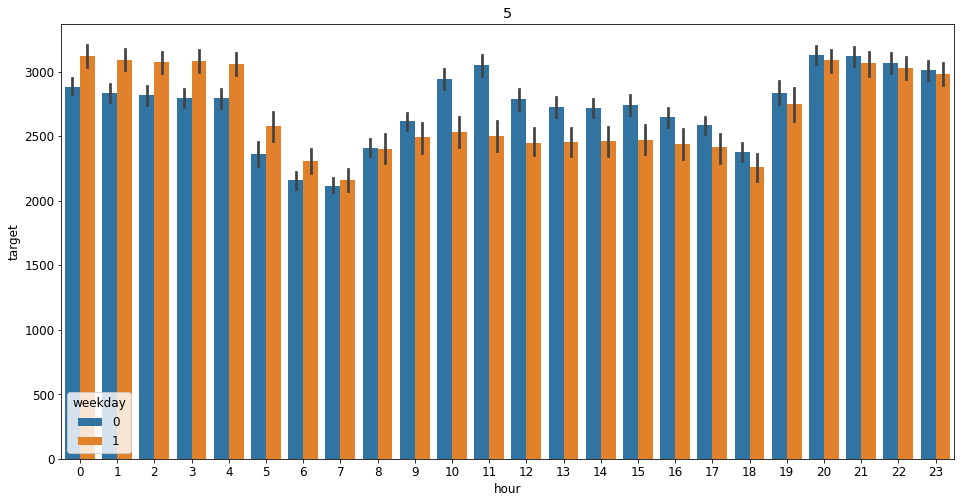

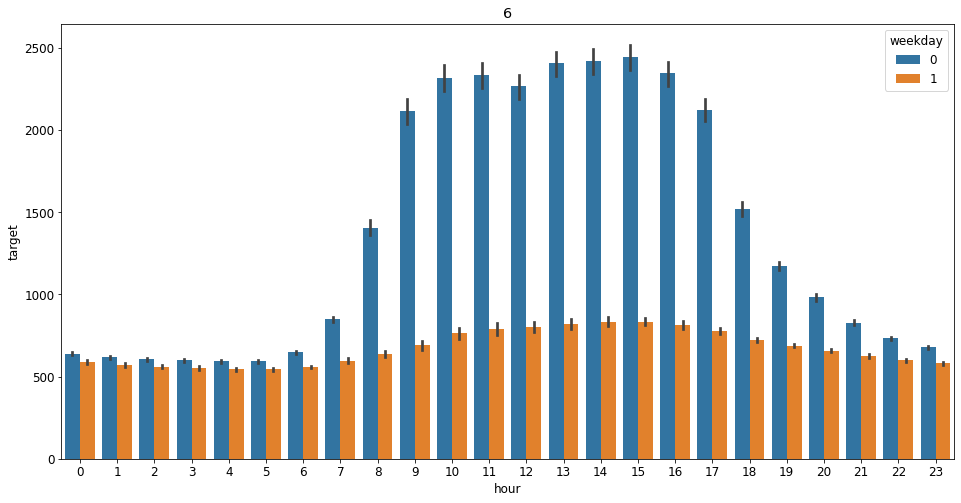

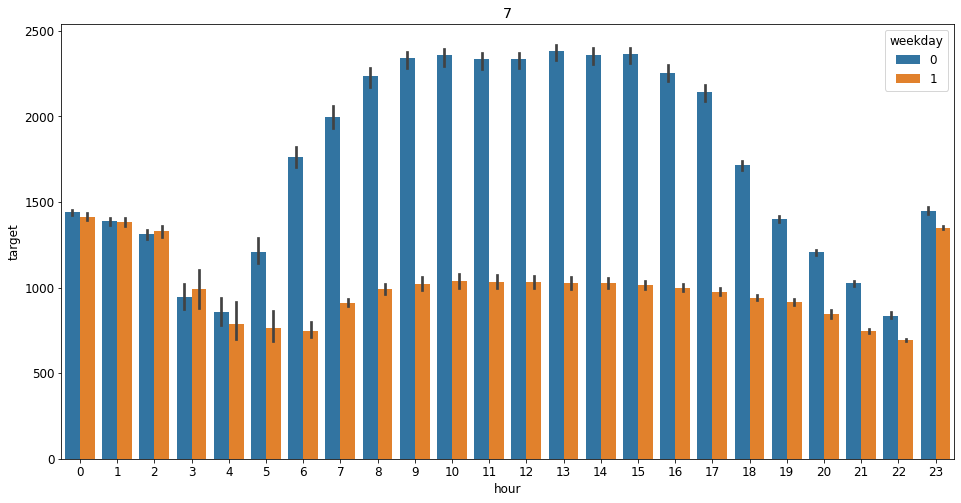

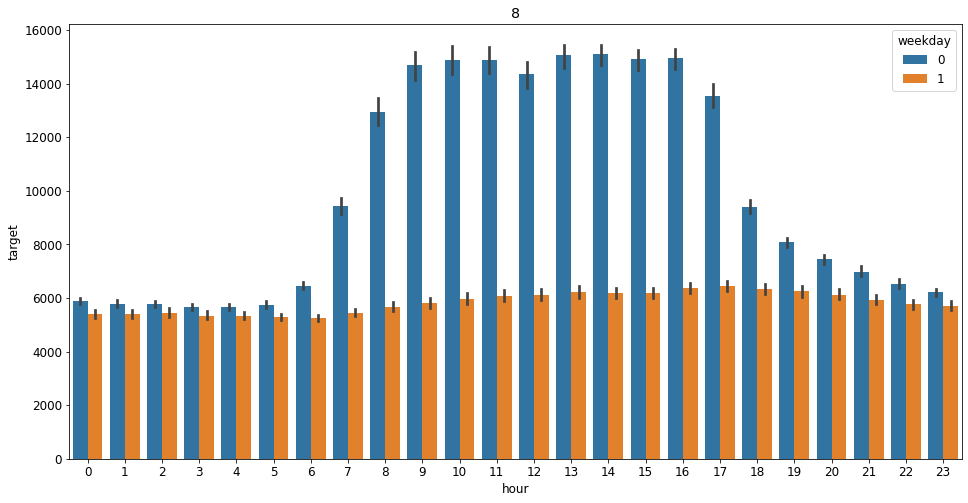

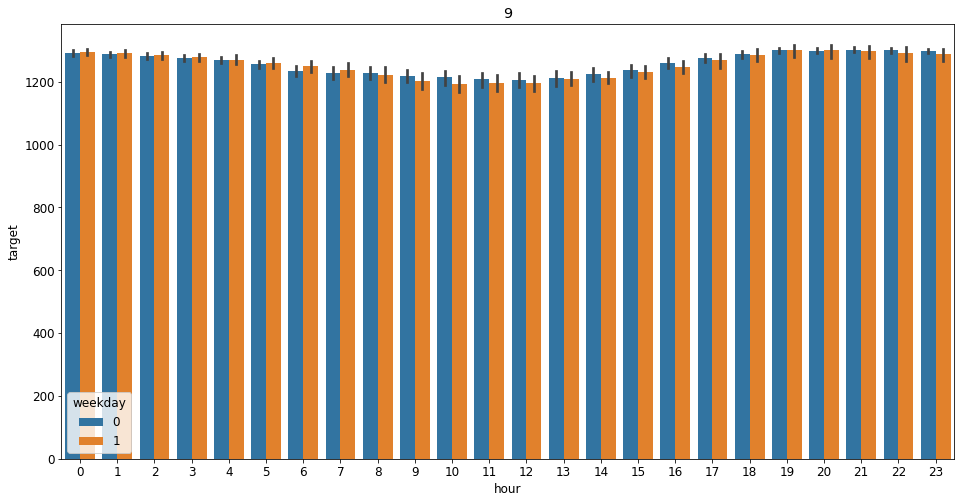

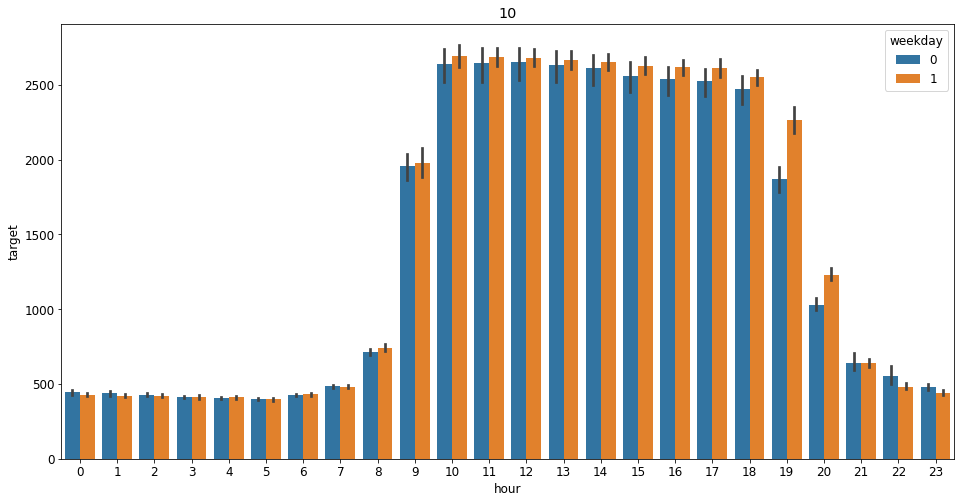

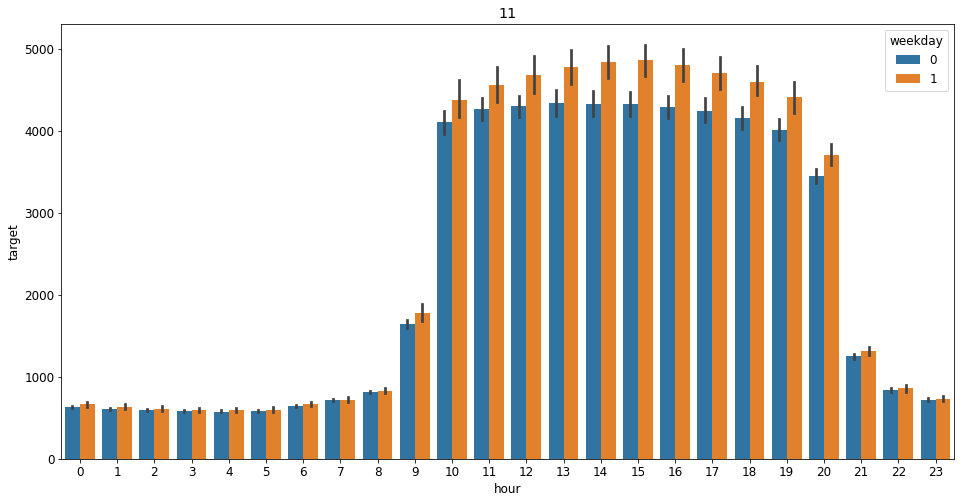

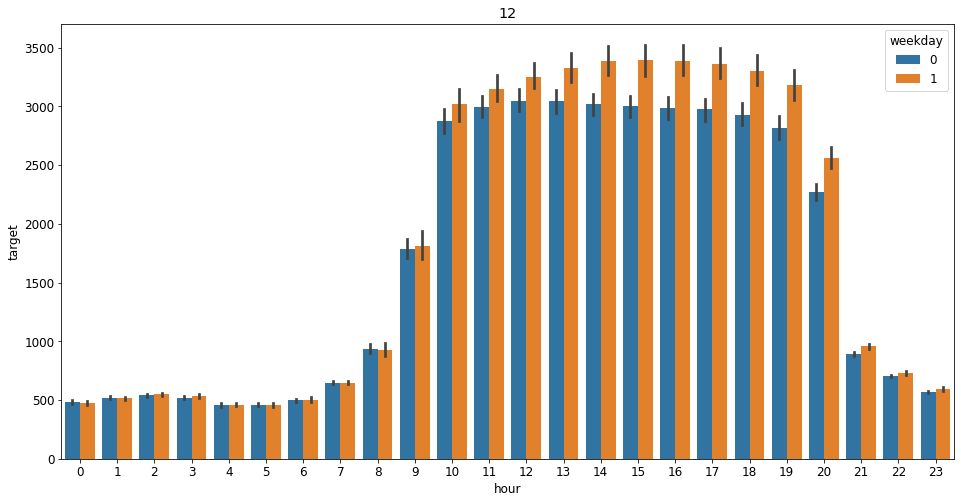

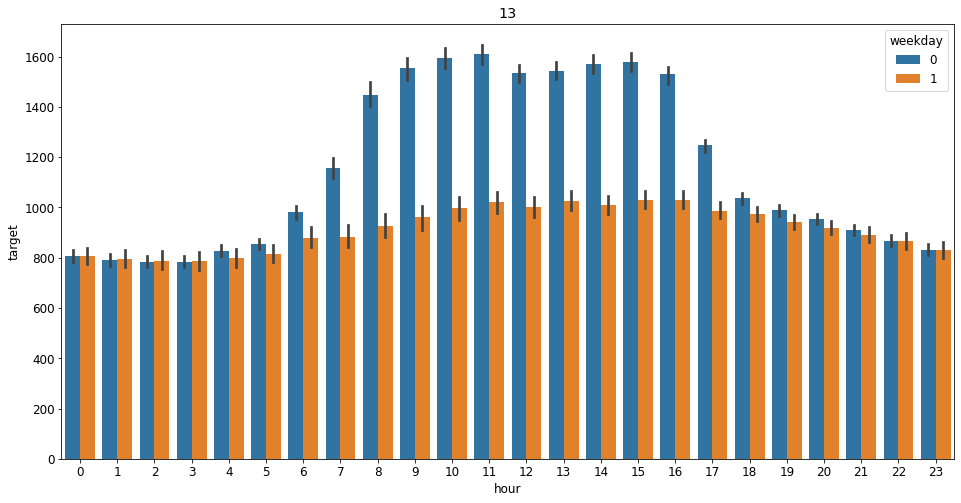

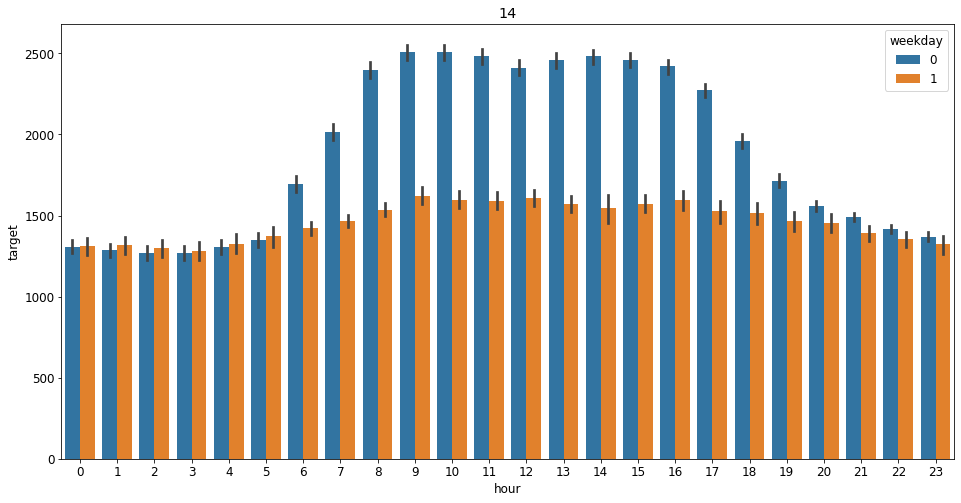

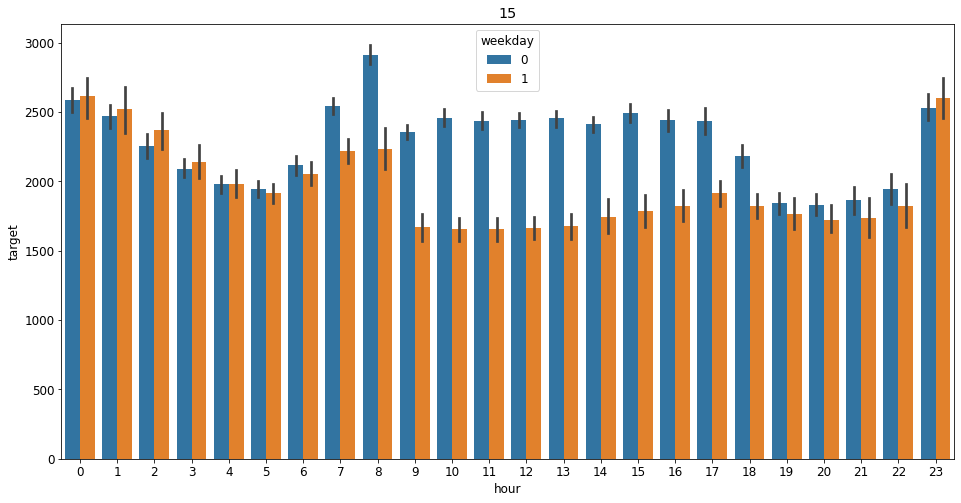

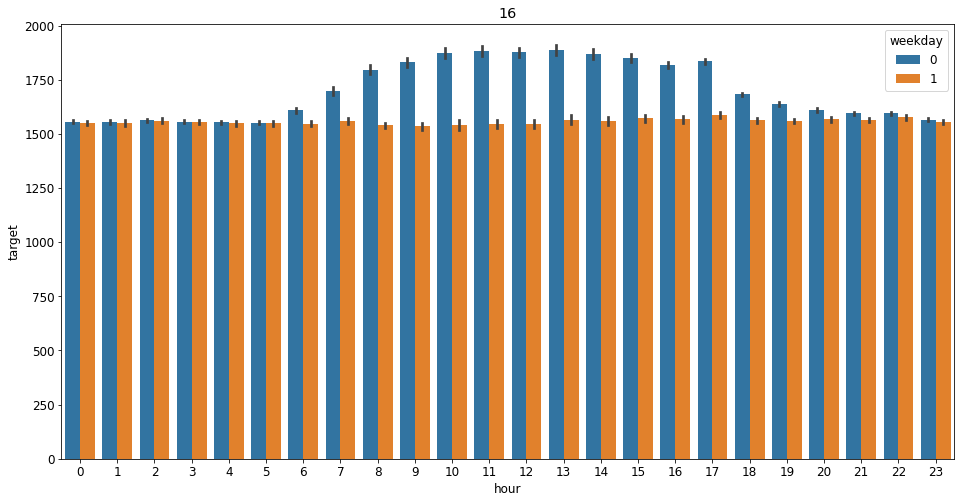

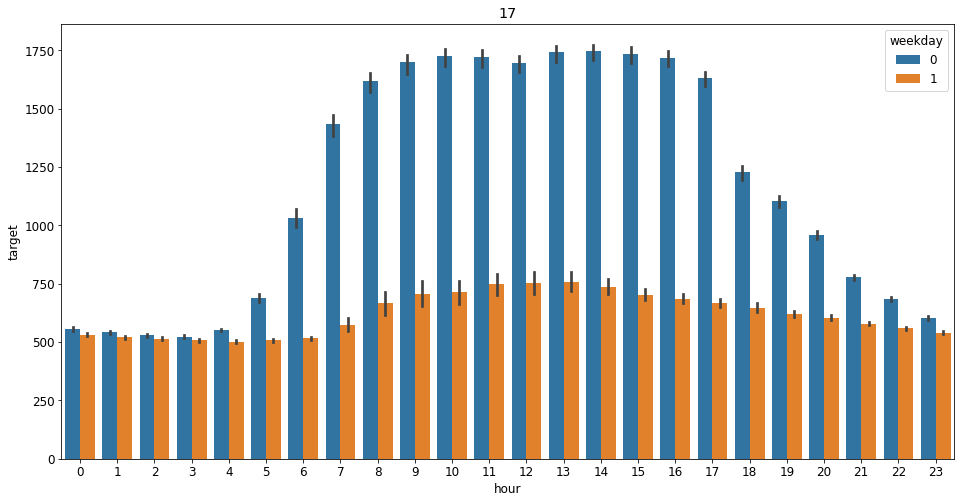

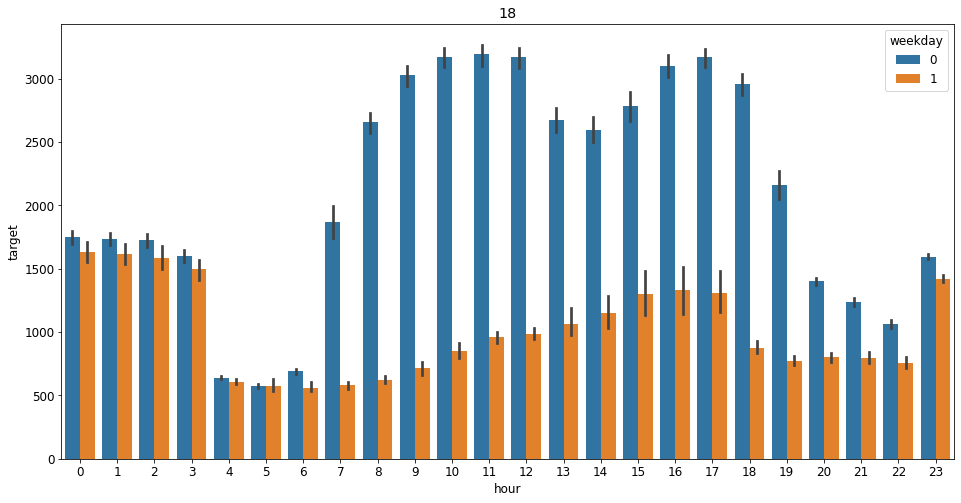

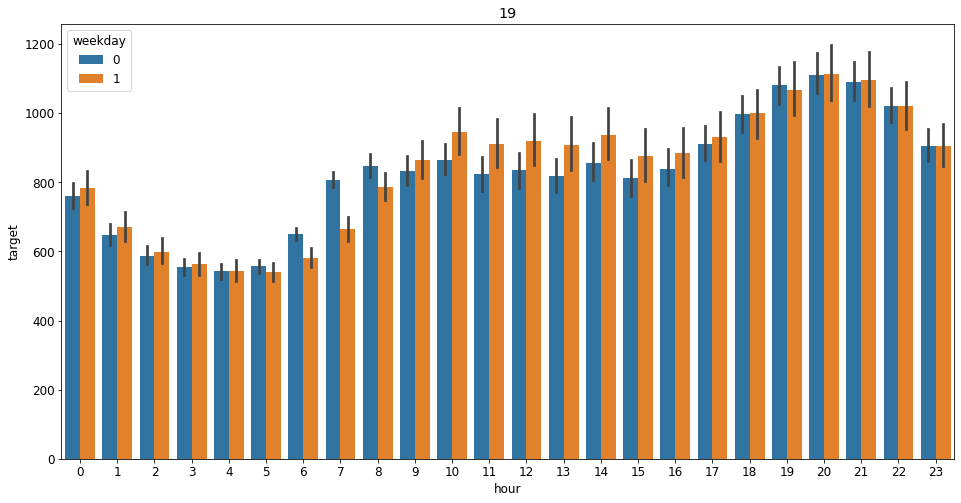

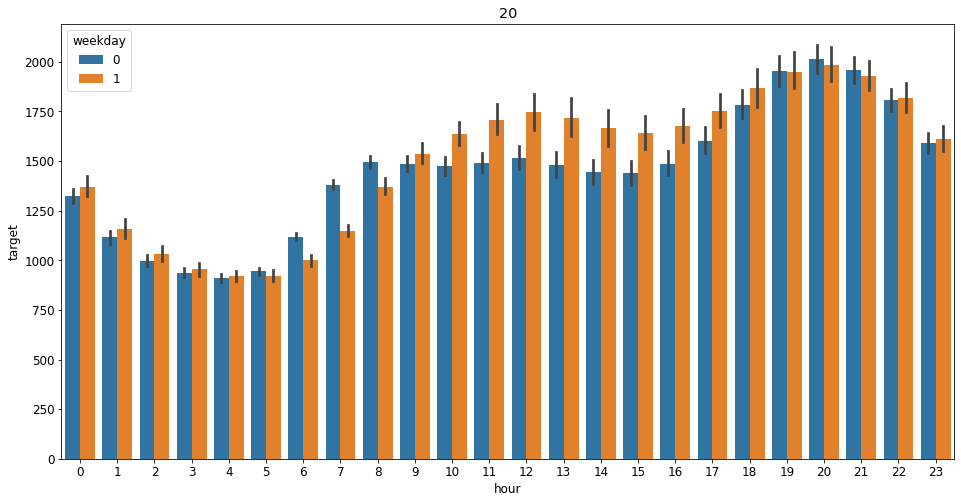

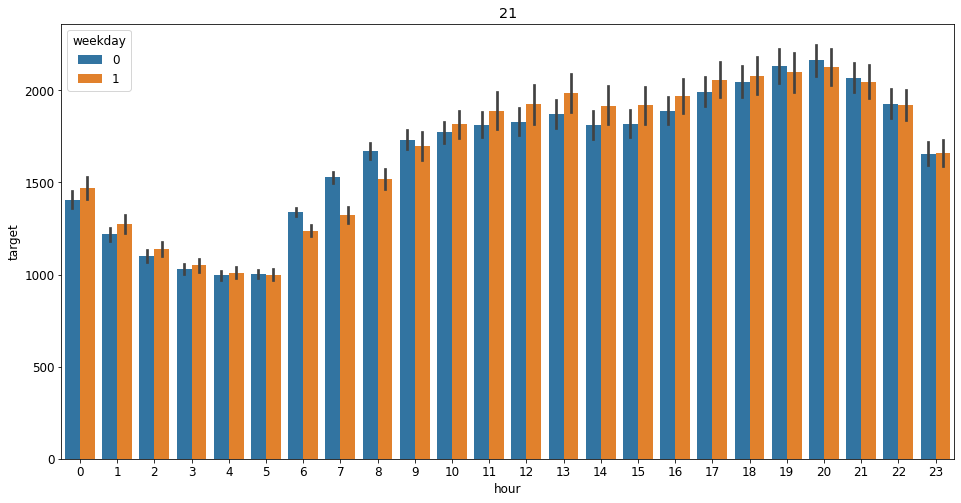

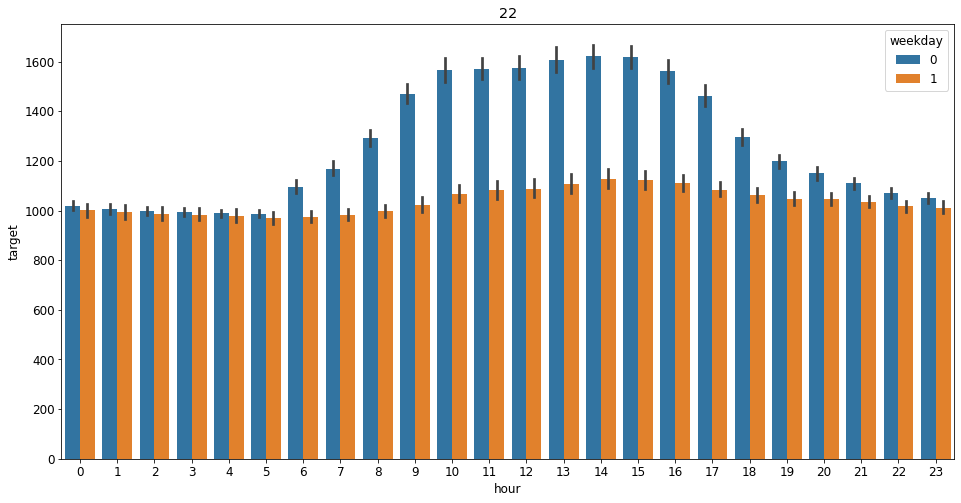

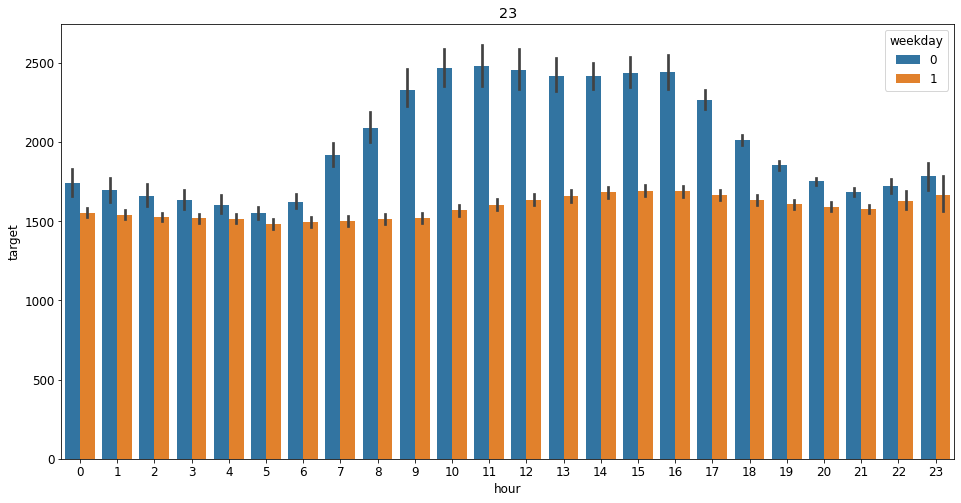

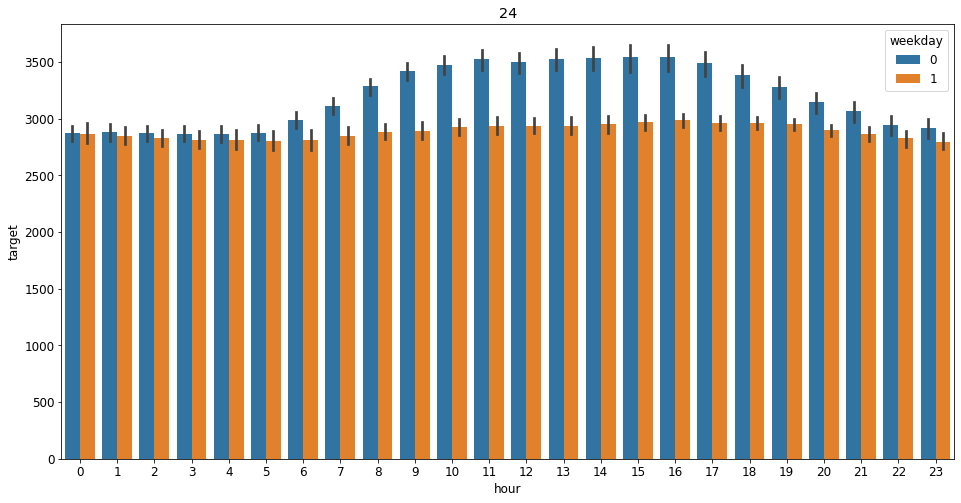

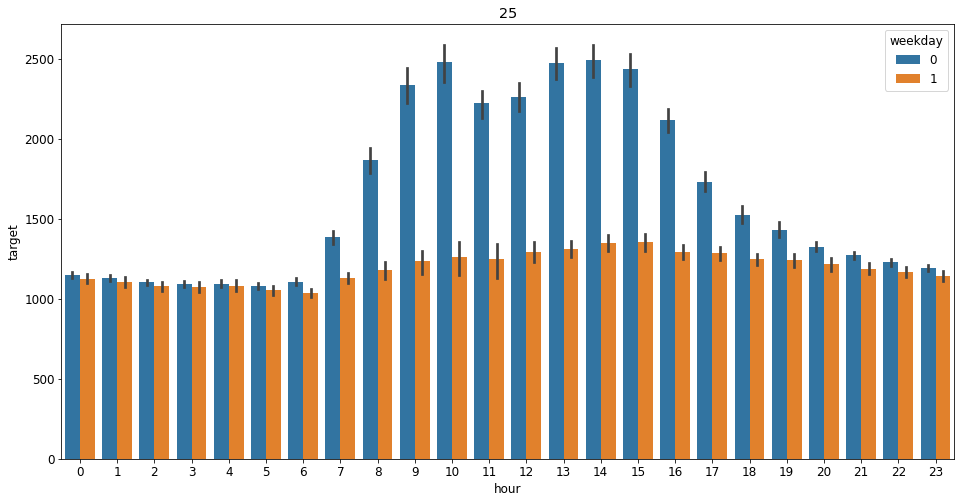

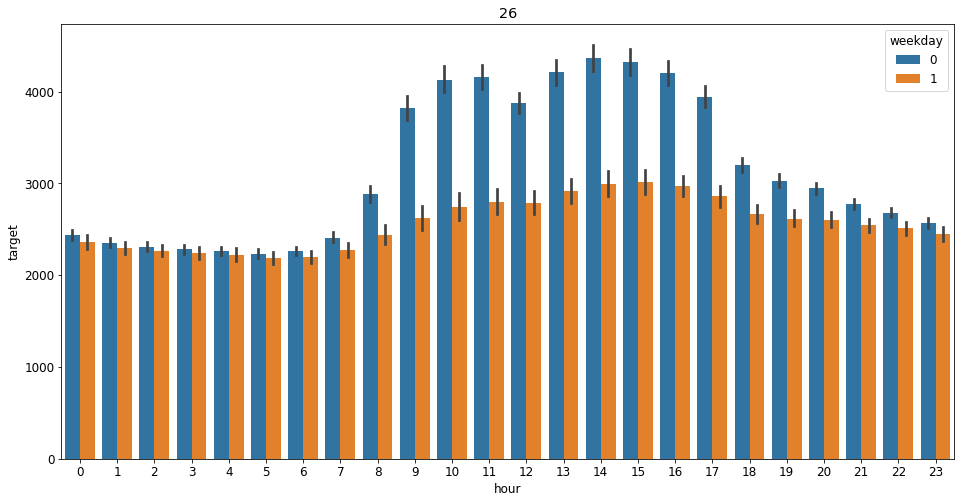

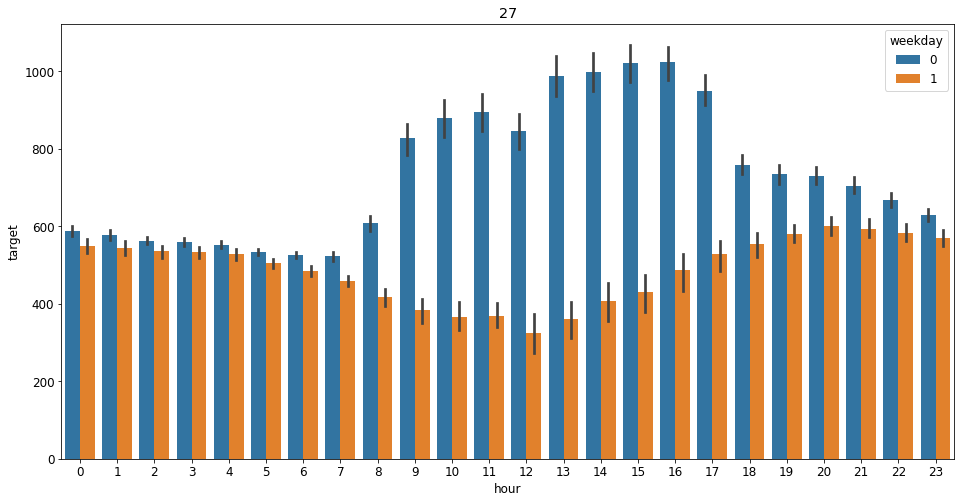

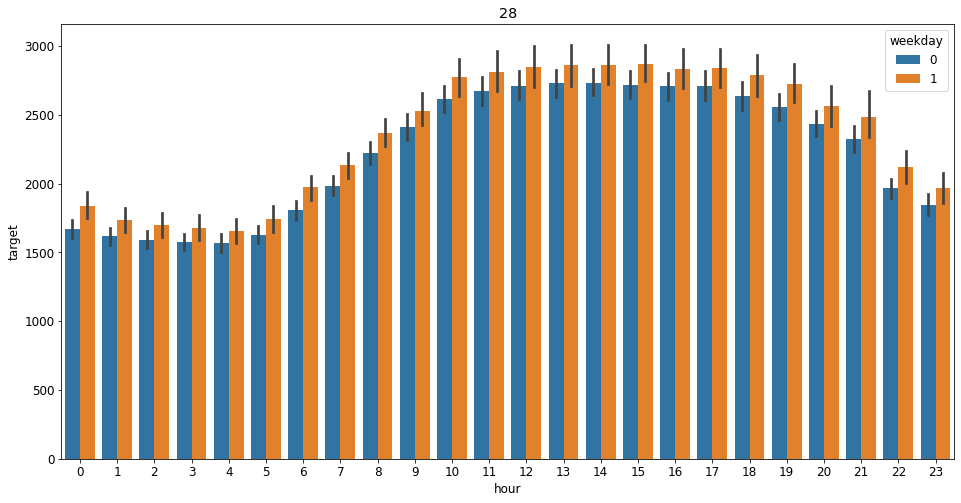

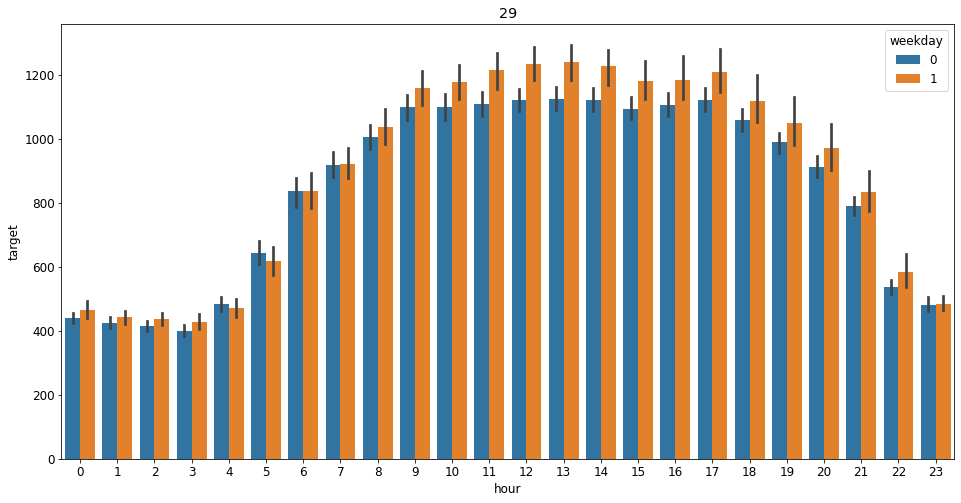

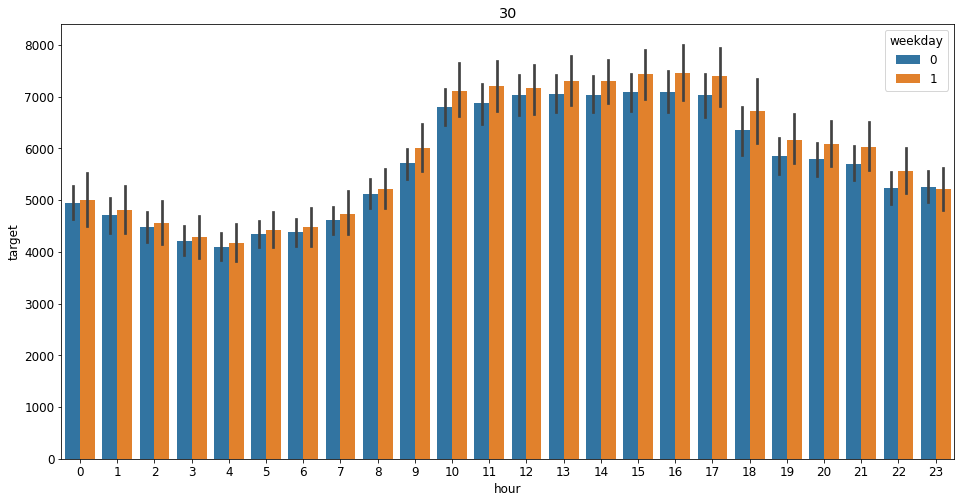

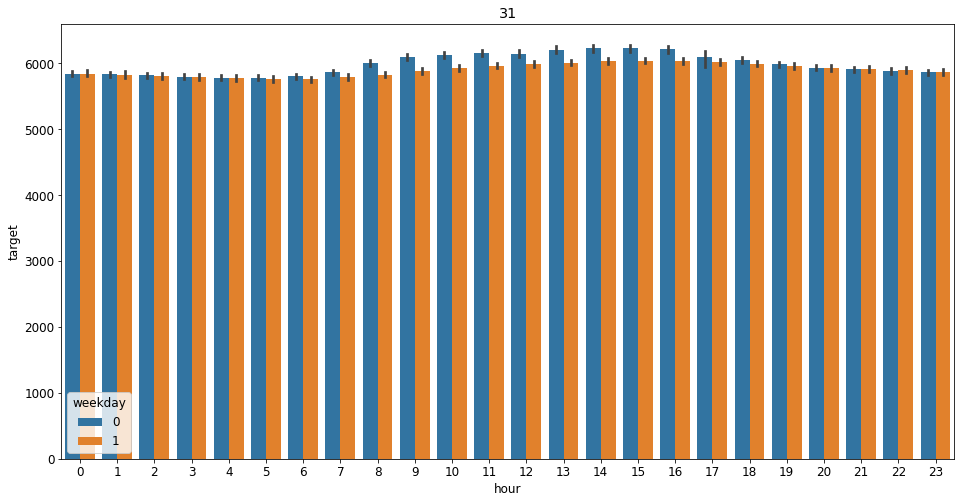

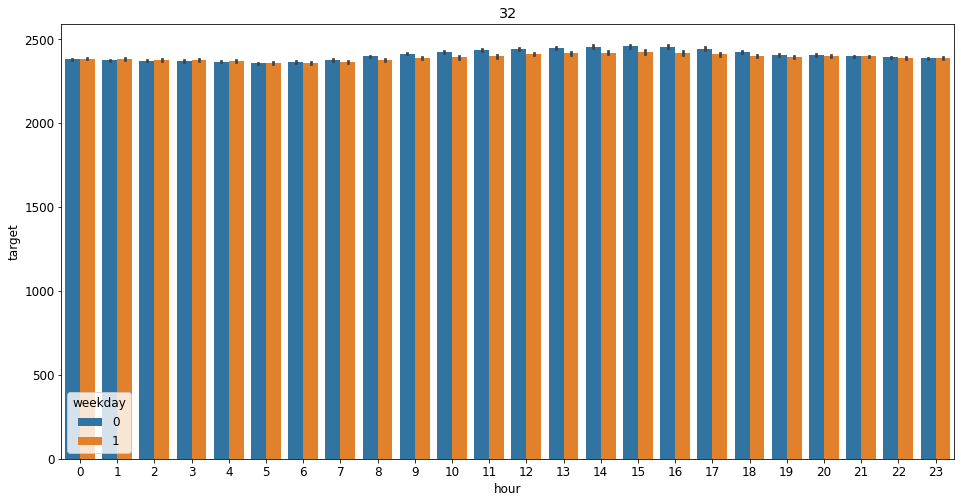

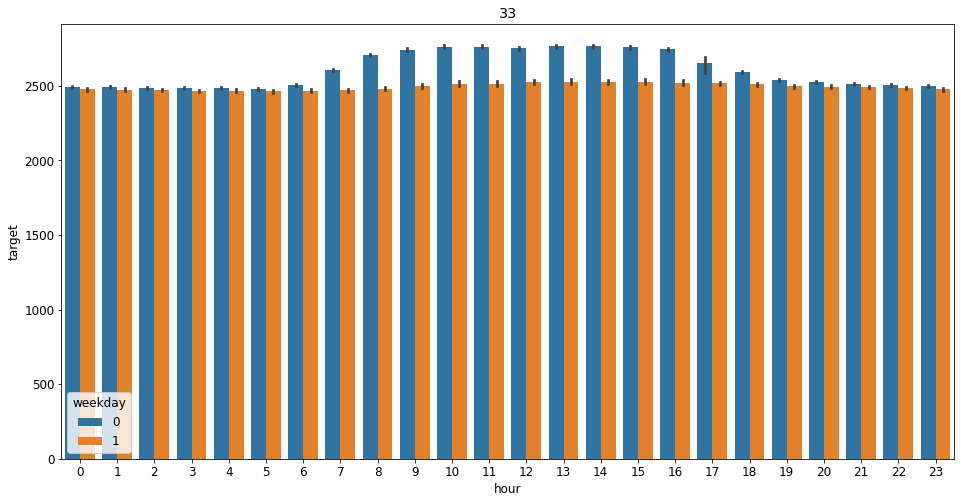

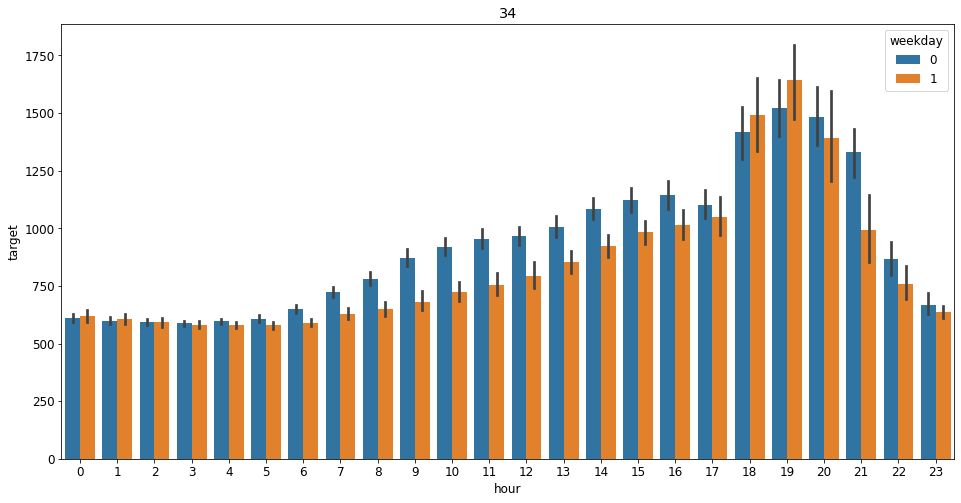

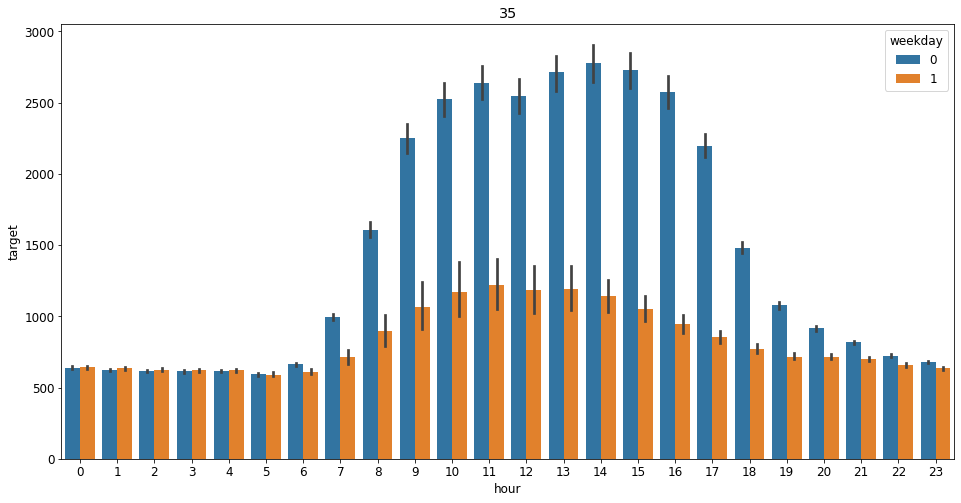

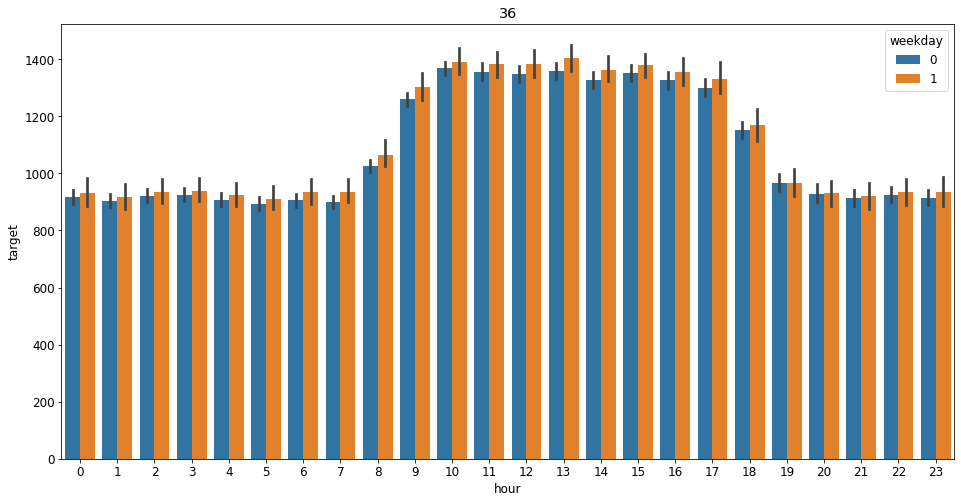

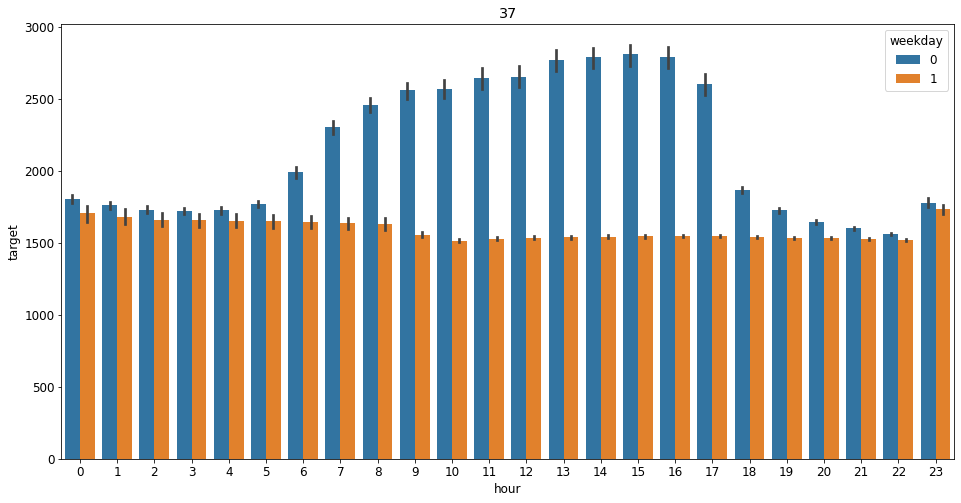

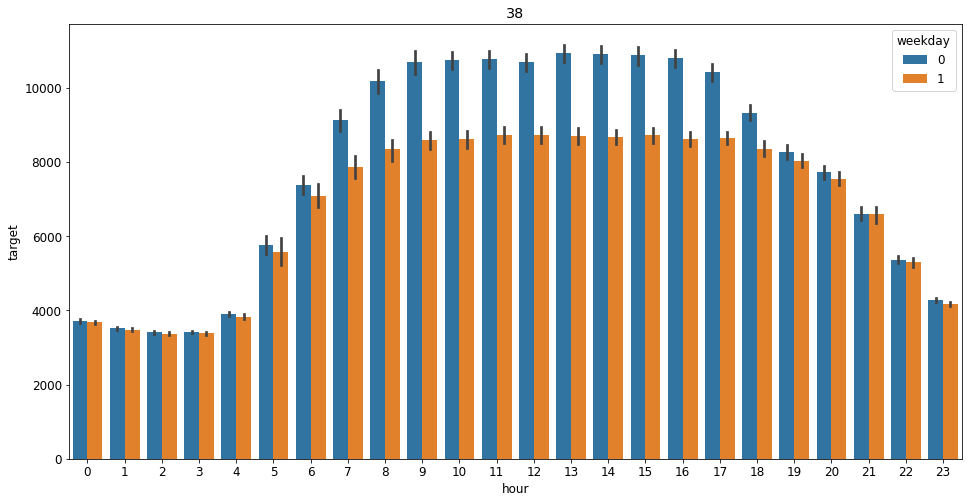

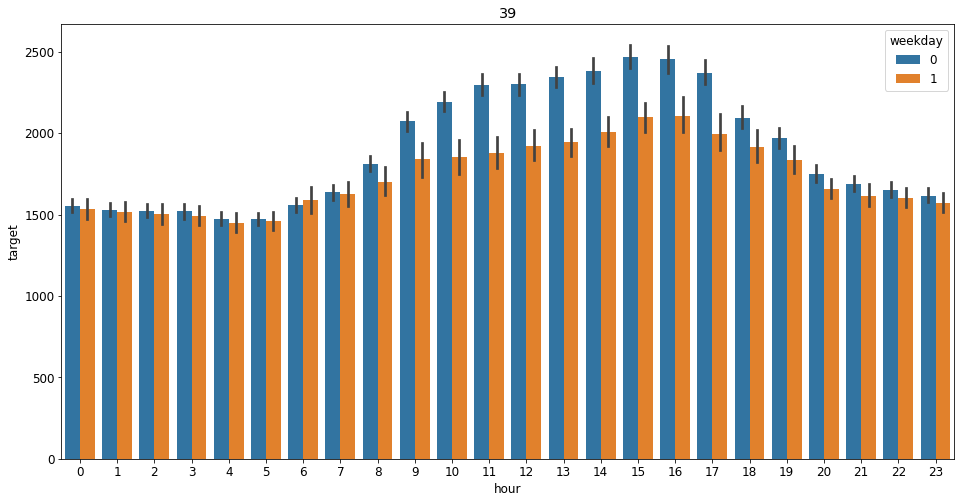

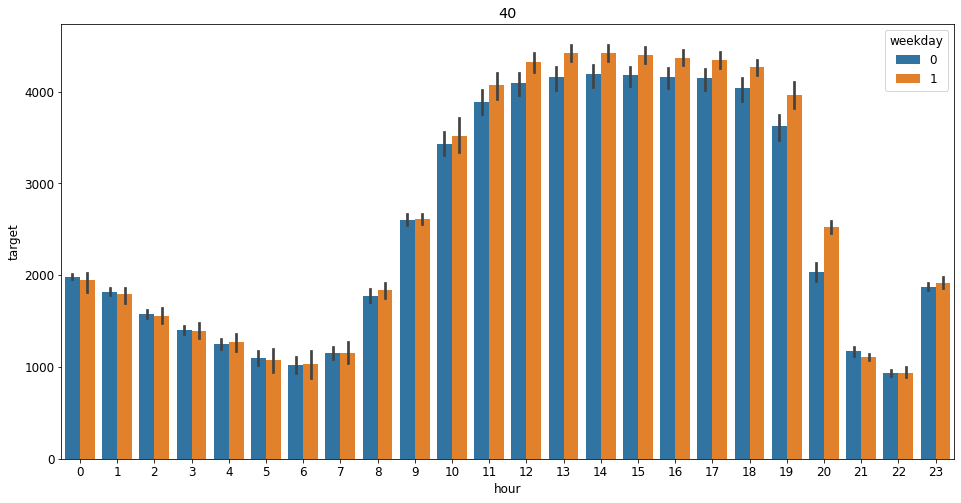

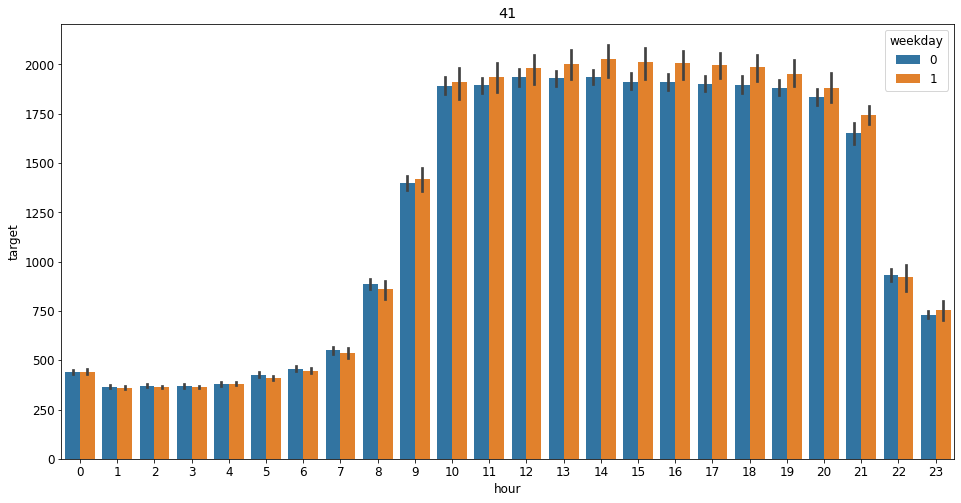

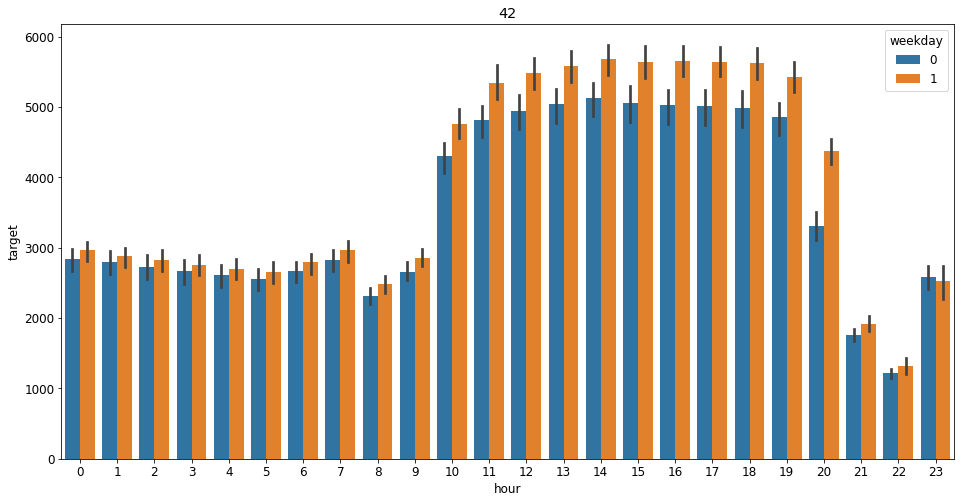

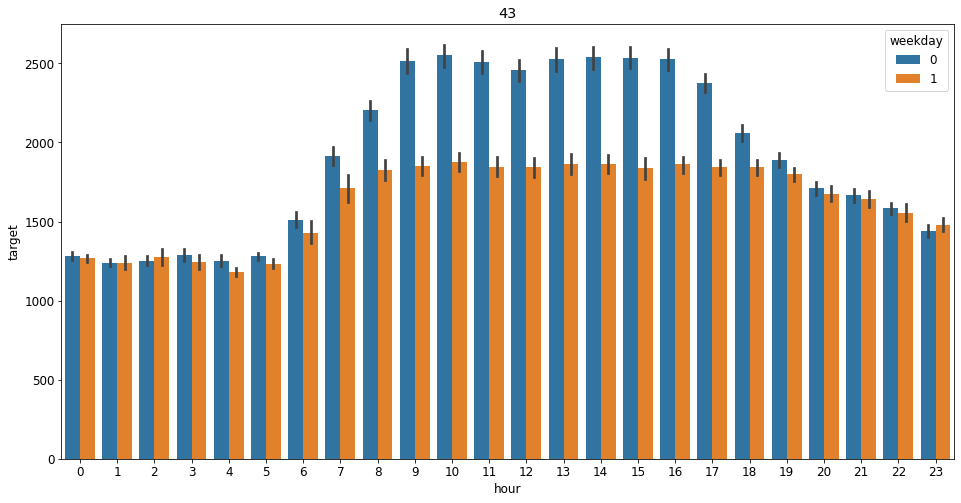

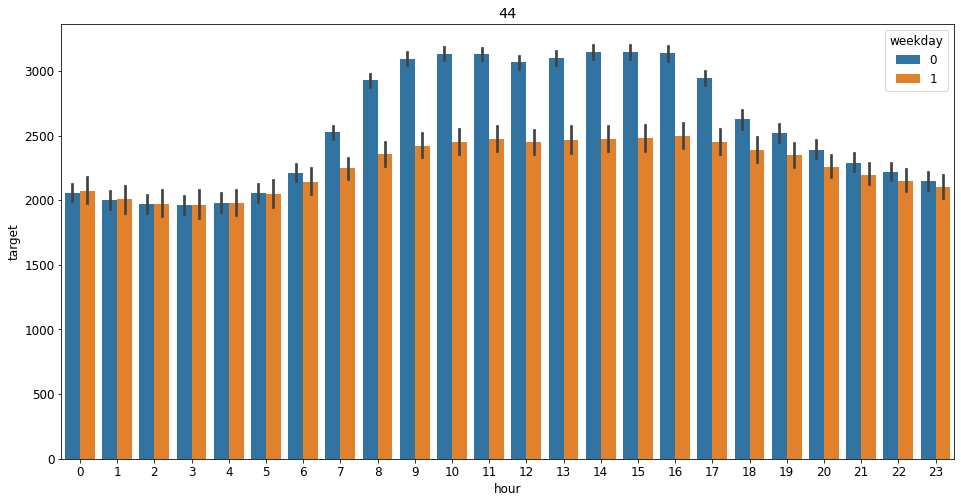

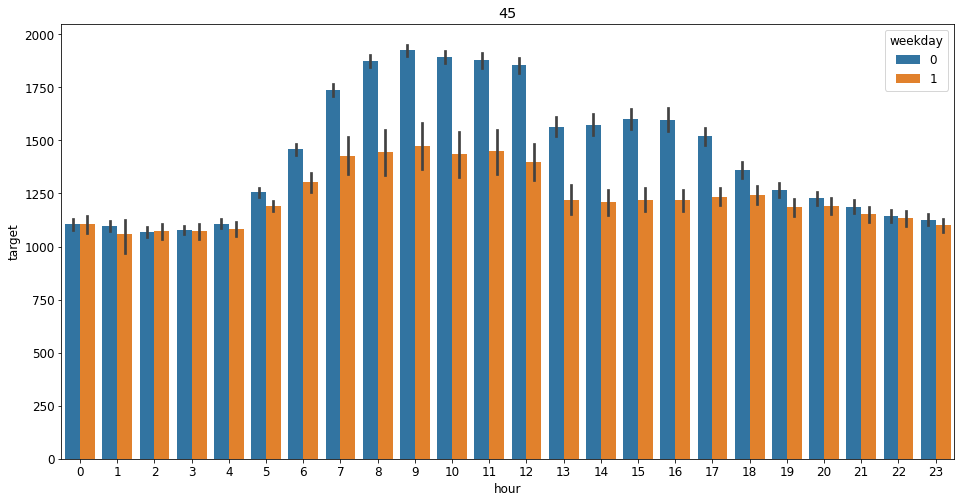

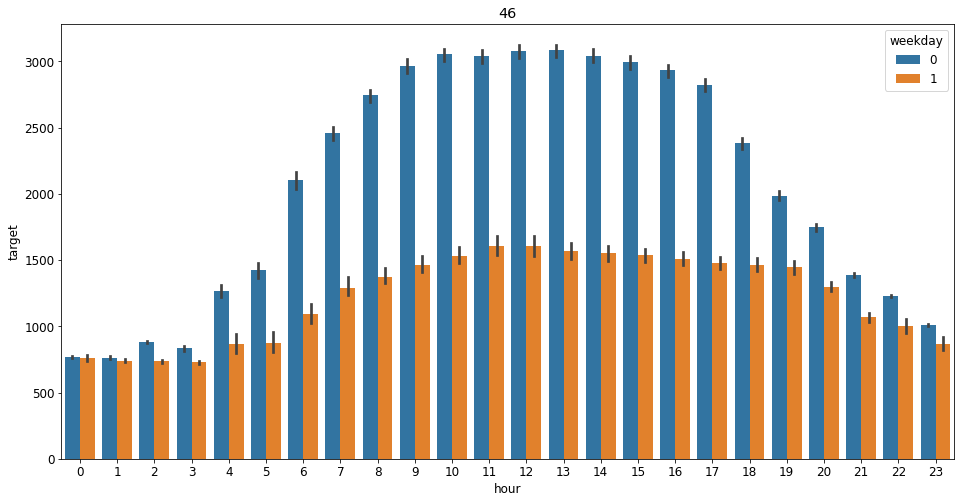

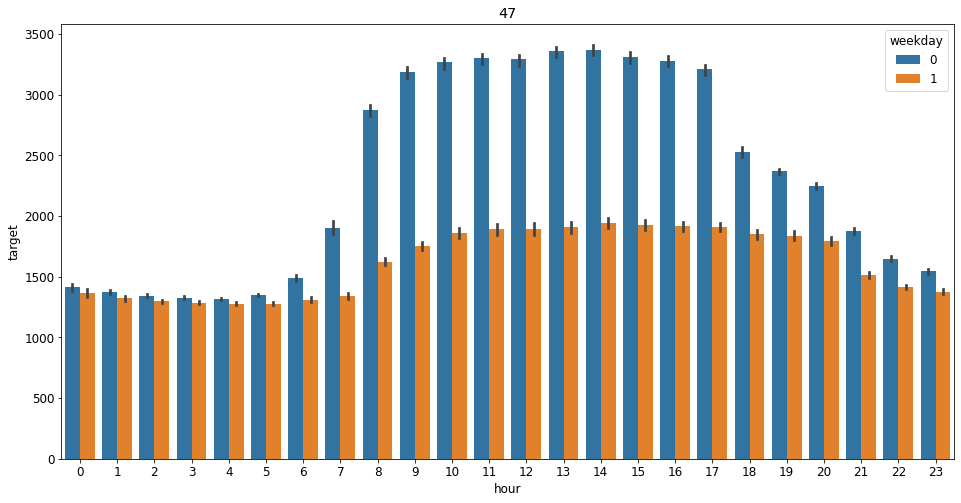

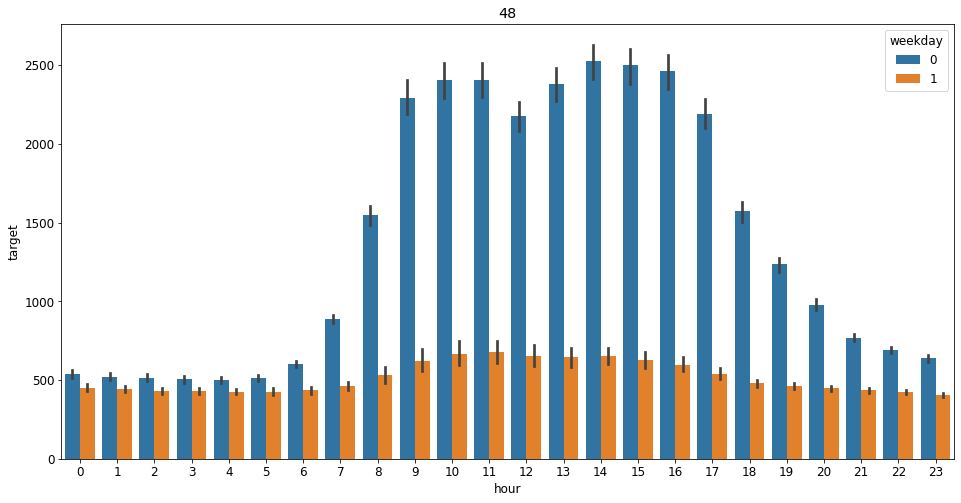

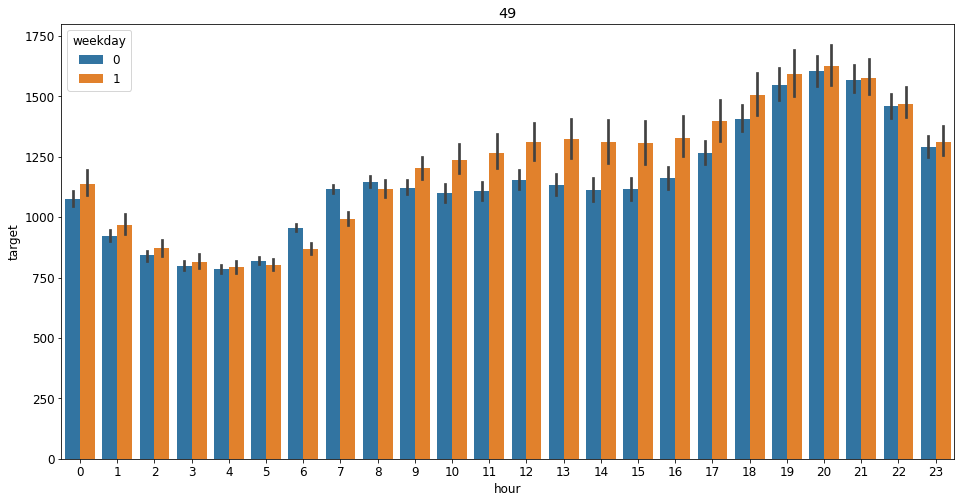

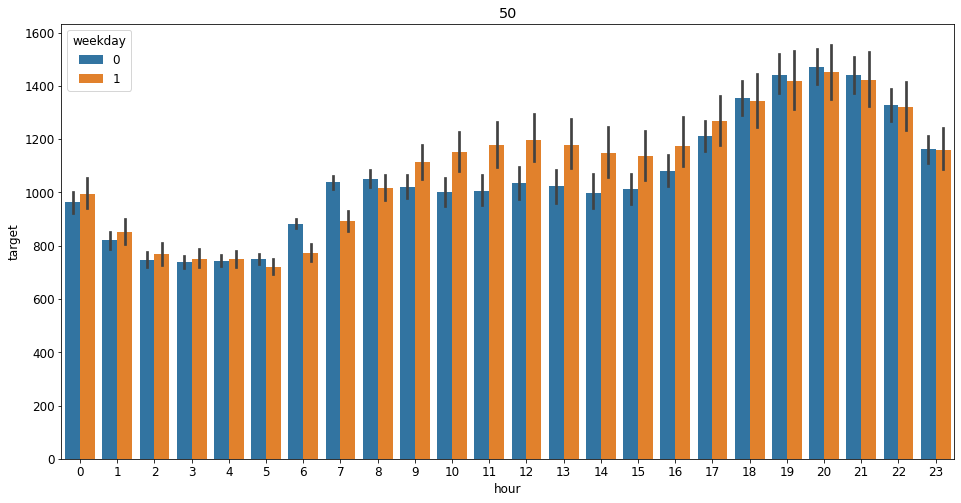

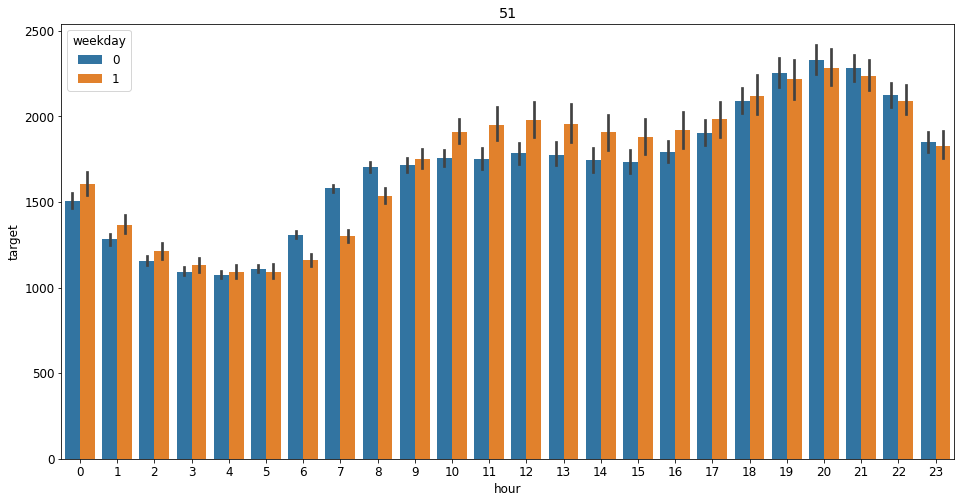

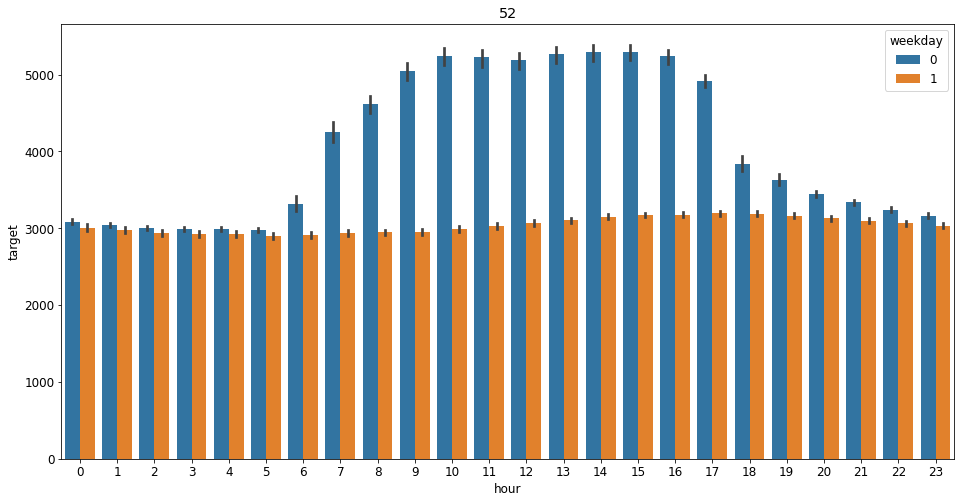

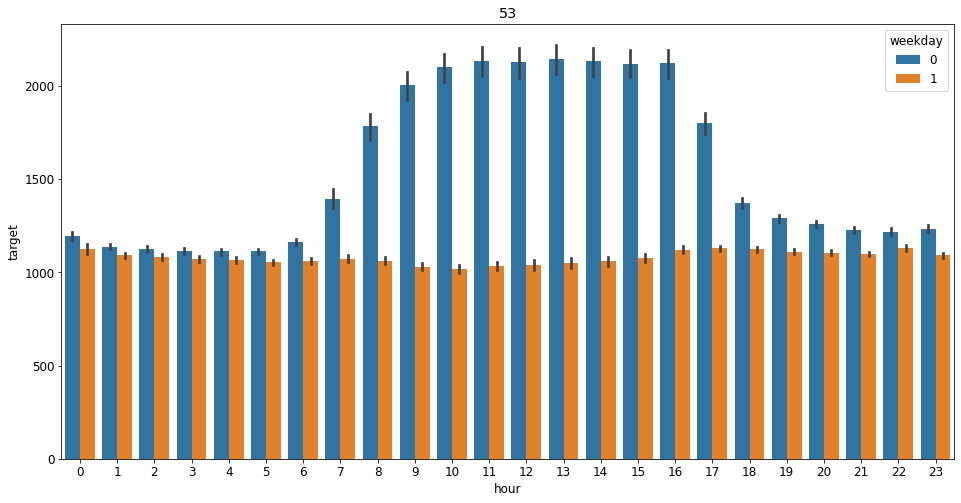

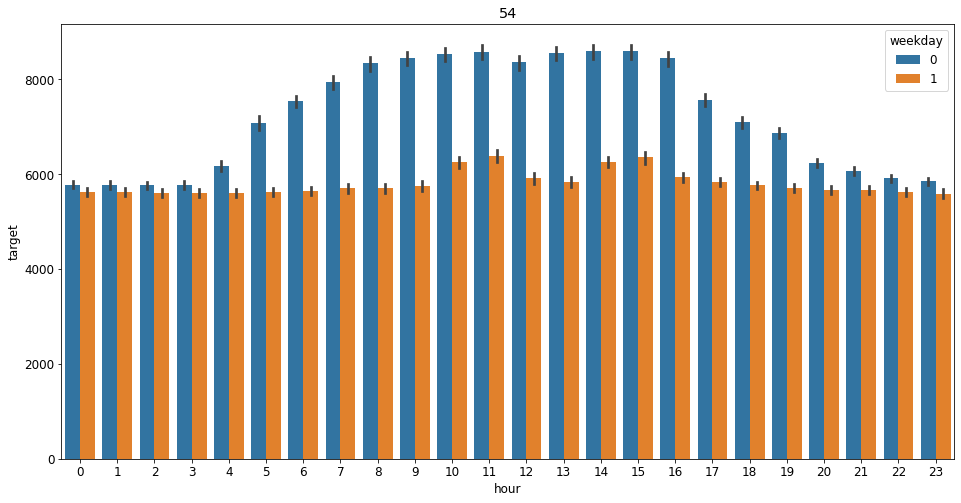

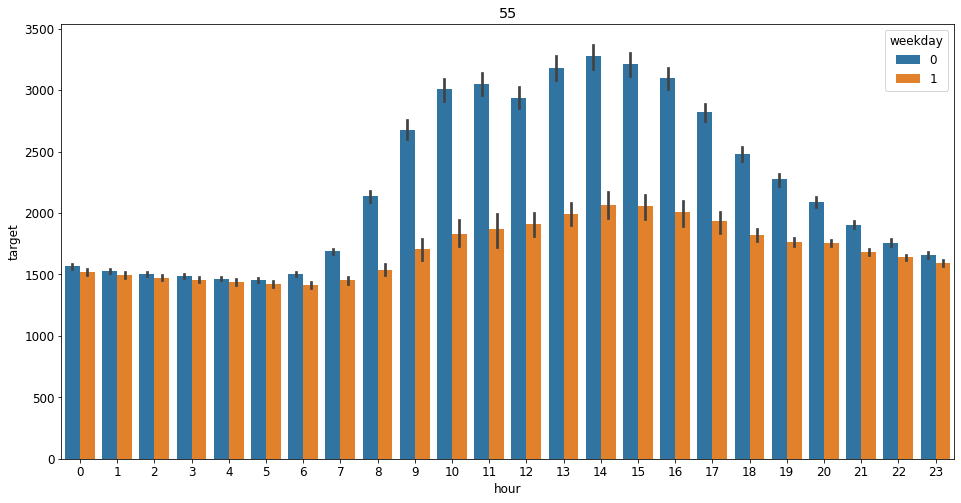

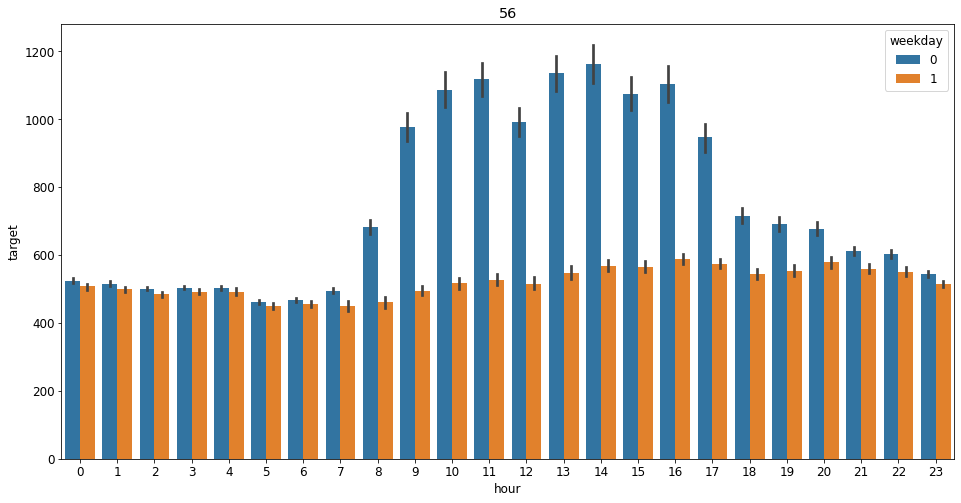

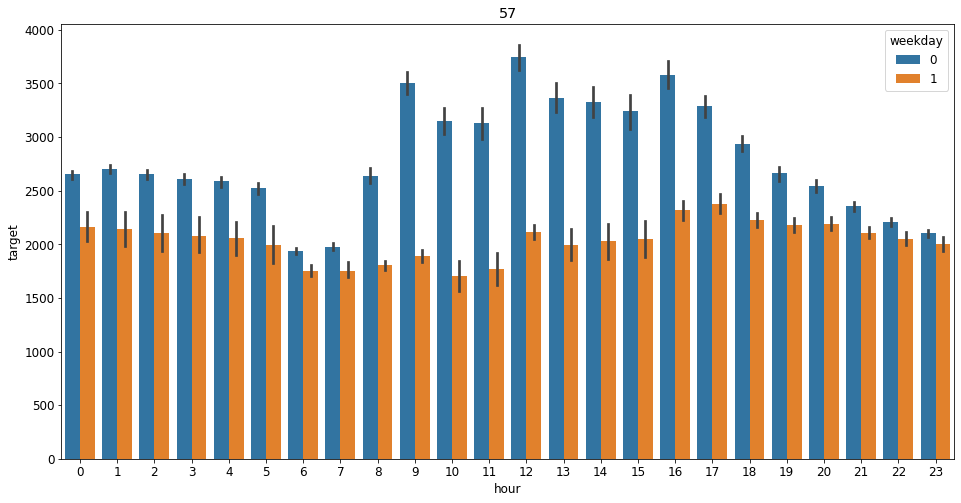

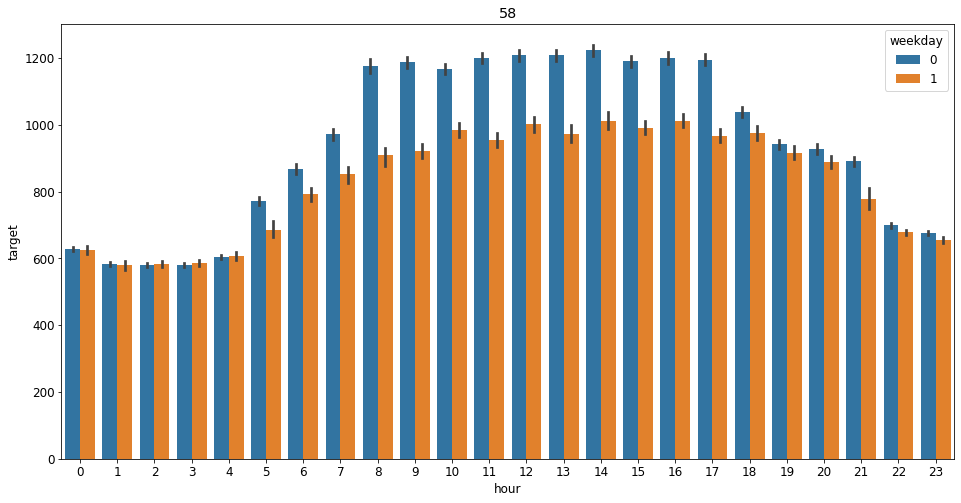

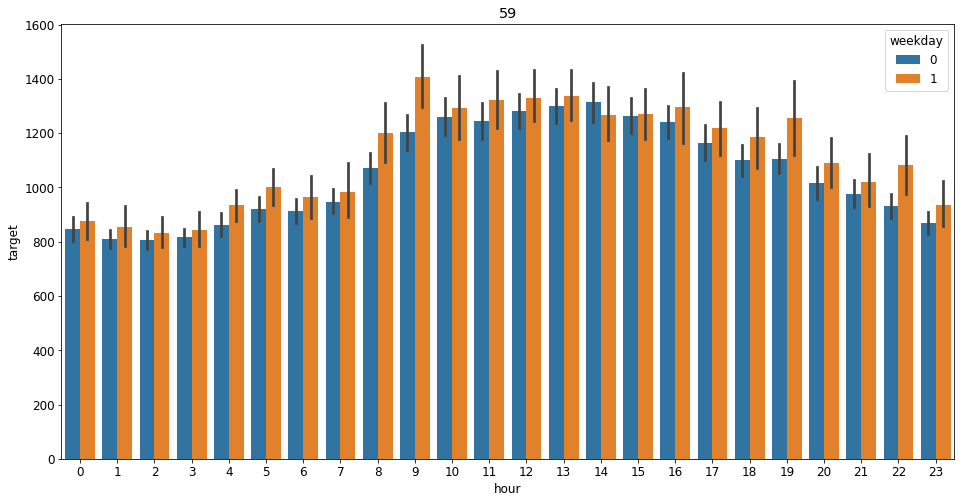

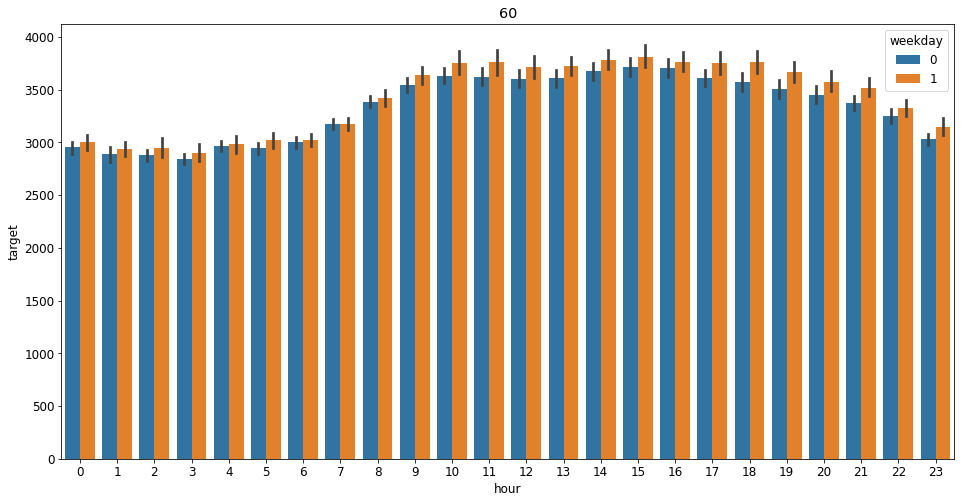

In [ ]:
# num으로 찍어본 결과 시간별로 차이가 극명하기 때문에 나눠주기 힘들 것 같다.
for i in train['num'].unique():
  sns.barplot(data = train[train['num'] == i], x = 'hour', y = 'target', hue = 'weekday')
  plt.title(f'{i}')
  plt.show()

## 모델링

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 75kB/s 


In [ ]:
train.isnull().sum()

num              0
date_time        0
target           0
Temperatures     0
Wind speed       0
Humidity         0
Precipitation    0
sunshine         0
비전기냉방설비운영        0
태양광보유            0
log_target       0
month            0
day              0
hour             0
weekday          0
working          0
new_column       0
열지수              0
불쾌지수             0
냉방도일             0
dtype: int64

In [95]:
# 우리는 모델을 num별로 돌려줄 예정이다.
train['month'] = train['month'].astype('int')
test['month'] = test['month'].astype('int')

a = []
for i in train['num'].unique():
  a.append(train[train['num'] == i])

# test 데이터도 똑같이 진행해 준다.
b = []
for i in test['num'].unique():
  b.append(test[test['num'] == i])

a[1]['working'] = a[1].apply(lambda x:1 if 6 < x < 19 else 0)
# # 더미화를 원래 하던 방식대로 진행해 주자.
# dummies = ['weekday','hour'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
# drop_columns_train = ['day','date_time','비전기냉방설비운영','태양광보유','num','target','Temperatures','new_column']
# for index,train_num in enumerate(a):
#   a[index] = pd.get_dummies(data = a[index] , columns = dummies)
#   a[index] = a[index].drop(drop_columns_train, axis = 1)


# # test 데이터도 똑같이 진행해 준다.
# b = []
# for i in test['num'].unique():
#   b.append(test[test['num'] == i])

# # 더미화를 원래 하던 방식대로 진행해 주자.
# dummies = ['weekday','hour'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
# drop_columns_test = ['day','date_time','비전기냉방설비운영','태양광보유','num','Temperatures','new_column']
# for index,test_num in enumerate(b):
#   b[index] = pd.get_dummies(data = b[index] , columns = dummies)
#   b[index] = b[index].drop(drop_columns_test, axis = 1)

# # 모델 돌려주기 우리는 각 num마다 좋은 성능을 내는지 확인하기 위해서 하는 것이므로
# # 가장 빠른 lightgbm을 사용해주자.
# from lightgbm import LGBMRegressor
# lgb = LGBMRegressor()
# final_y_pred = []
# for i in range(len(a)):
#   lgb.fit(a[i].drop('log_target', axis = 1), a[i]['log_target'])
#   y_pred = lgb.predict(b[i])
#   final_y_pred.append(y_pred)

# 끄악 = []
# for y_pred in final_y_pred:
#   for j in y_pred:
#     끄악.append(j)

# y_pred = pd.DataFrame(끄악, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# submission['answer'] = y_pred
# submission.to_csv('submission.csv',index= False)

,num,date_time,target,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유,log_target,month,day,hour,weekday,working,new_column,열지수,불쾌지수,냉방도일
2040,2,2020-06-01 00:00:00,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0,6.885698,6,01,0,0,1.0,2.0,61.264531,0,-7.7
2041,2,2020-06-01 01:00:00,966.168,18.8,2.3,89.0,0.0,0.0,1.0,0.0,6.874372,6,01,1,0,1.0,2.0,64.911053,0,-14.9
2042,2,2020-06-01 02:00:00,972.972,19.0,3.2,86.0,0.0,0.0,1.0,0.0,6.881383,6,01,2,0,1.0,2.0,66.772958,0,-21.9
2043,2,2020-06-01 03:00:00,965.844,19.0,4.1,85.0,0.0,0.0,1.0,0.0,6.874037,6,01,3,0,1.0,2.0,67.334499,0,-28.9
2044,2,2020-06-01 04:00:00,971.676,18.9,3.9,87.0,0.0,0.0,1.0,0.0,6.880051,6,01,4,0,1.0,2.0,66.163230,0,-36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,2,2020-08-24 19:00:00,1353.348,27.9,1.7,83.0,0.0,0.6,1.0,0.0,7.211075,8,24,19,0,1.0,2.0,90.146100,2,46.9
4076,2,2020-08-24 20:00:00,1260.036,27.4,1.4,83.0,0.0,0.0,1.0,0.0,7.139689,8,24,20,0,1.0,2.0,87.817042,2,46.4
4077,2,2020-08-24 21:00:00,1214.028,27.1,1.4,86.0,0.0,0.0,1.0,0.0,7.102522,8,24,21,0,1.0,2.0,87.051442,2,44.5
4078,2,2020-08-24 22:00:00,1126.224,26.9,0.0,84.0,0.0,0.0,1.0,0.0,7.027513,8,24,22,0,1.0,2.0,85.784861,2,41.9


In [100]:
# num = 2
a[1]['working'] = a[1]['hour'].apply(lambda x:1 if ((6 < x) & (x < 19))  else 0)
b[1]['working'] = b[1]['hour'].apply(lambda x:1 if ((6 < x) & (x < 19))  else 0)

# num = 4
a[3]['working'] = a[3]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)
b[3]['working'] = b[3]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)

# num = 6
a[5]['working'] = a[5]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)
b[5]['working'] = b[5]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)

# num = 7
a[6]['working'] = a[6]['hour'].apply(lambda x:1 if ((5 < x) & (x < 19)) else 0)
b[6]['working'] = b[6]['hour'].apply(lambda x:1 if ((5 < x) & (x < 19)) else 0)

# num = 8 7 18
a[7]['working'] = a[7]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)
b[7]['working'] = b[7]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)

# num = 10 9 19
a[9]['working'] = a[9]['hour'].apply(lambda x:1 if ((9 < x) & (x < 19)) else 0)
b[9]['working'] = b[9]['hour'].apply(lambda x:1 if ((9 < x) & (x < 19)) else 0)

# num = 11 10 ~ 20
a[10]['working'] = a[10]['hour'].apply(lambda x:1 if ((10 < x) & (x < 20)) else 0)
b[10]['working'] = b[10]['hour'].apply(lambda x:1 if ((10 < x) & (x < 20)) else 0)

# num = 12 9 ~ 20
a[11]['working'] = a[11]['hour'].apply(lambda x:1 if ((9 < x) & (x < 20)) else 0)
b[11]['working'] = b[11]['hour'].apply(lambda x:1 if ((9 < x) & (x < 20)) else 0)

# num = 13 7 17 
a[12]['working'] = a[12]['hour'].apply(lambda x:1 if ((7 < x) & (x < 17)) else 0)
b[12]['working'] = b[12]['hour'].apply(lambda x:1 if ((7 < x) & (x < 17)) else 0)

# num = 14 6 19
a[13]['working'] = a[13]['hour'].apply(lambda x:1 if ((6 < x) & (x < 19)) else 0)
b[13]['working'] = b[13]['hour'].apply(lambda x:1 if ((6 < x) & (x < 19)) else 0)

# num = 15 7 18
a[14]['working'] = a[14]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)
b[14]['working'] = b[14]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)

# num = 16 7 17
a[15]['working'] = a[15]['hour'].apply(lambda x:1 if ((7 < x) & (x < 17)) else 0)
b[15]['working'] = b[15]['hour'].apply(lambda x:1 if ((7 < x) & (x < 17)) else 0)

# num = 17 5 21
a[16]['working'] = a[16]['hour'].apply(lambda x:1 if ((5 < x) & (x < 21)) else 0)
b[16]['working'] = b[16]['hour'].apply(lambda x:1 if ((5 < x) & (x < 21)) else 0)

# num = 18 7 20
a[17]['working'] = a[17]['hour'].apply(lambda x:1 if ((7 < x) & (x < 20)) else 0)
b[17]['working'] = b[17]['hour'].apply(lambda x:1 if ((7 < x) & (x < 20)) else 0)

# num = 22 7 19
a[21]['working'] = a[21]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)
b[21]['working'] = b[21]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)

# num = 23 
a[6]['working'] = a[6]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)
a[6]['working'] = a[6]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)

# num = 24
a[23]['working'] = a[23]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)
b[23]['working'] = b[23]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)

# num = 25
a[24]['working'] = b[24]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)
b[24]['working'] = b[24]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)

# num = 26
a[25]['working'] = a[25]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)
b[25]['working'] = b[25]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)

# num = 27
a[26]['working'] = a[26]['hour'].apply(lambda x:1 if ((8 < x) & (x < 20)) else 0)
b[26]['working'] = b[26]['hour'].apply(lambda x:1 if ((8 < x) & (x < 20)) else 0)

# num = 33 8 18
a[32]['working'] = a[32]['hour'].apply(lambda x:1 if ((8 < x) & (x < 18)) else 0)
b[32]['working'] = b[32]['hour'].apply(lambda x:1 if ((8 < x) & (x < 18)) else 0)

# num = 35 7 19
a[34]['working'] = a[34]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)
b[34]['working'] = b[34]['hour'].apply(lambda x:1 if ((7 < x) & (x < 19)) else 0)

# num = 37 6 18
a[36]['working'] = a[36]['hour'].apply(lambda x:1 if ((6 < x) & (x < 18)) else 0)
b[36]['working'] = b[36]['hour'].apply(lambda x:1 if ((6 < x) & (x < 18)) else 0)

# num = 38 7 18
a[37]['working'] = a[37]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)
b[37]['working'] = b[37]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)

# num = 39 8 18
a[38]['working'] = b[38]['hour'].apply(lambda x:1 if ((8 < x) & (x < 18)) else 0)
b[38]['working'] = b[38]['hour'].apply(lambda x:1 if ((8 < x) & (x < 18)) else 0)

# num = 43 7 18
a[42]['working'] = a[42]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)
b[42]['working'] = b[42]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)

# num = 44 7 18
a[43]['working'] = a[43]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)
b[43]['working'] = b[43]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)

# num = 45 6 17
a[44]['working'] = a[44]['hour'].apply(lambda x:1 if ((6 < x) & (x < 17)) else 0)
b[44]['working'] = b[44]['hour'].apply(lambda x:1 if ((6 < x) & (x < 17)) else 0)

# num = 46 4 21
a[45]['working'] = a[45]['hour'].apply(lambda x:1 if ((4 < x) & (x < 21)) else 0)
b[45]['working'] = b[45]['hour'].apply(lambda x:1 if ((4 < x) & (x < 21)) else 0)

# num = 47 7 21
a[46]['working'] = a[46]['hour'].apply(lambda x:1 if ((7 < x) & (x < 21)) else 0)
b[46]['working'] = b[46]['hour'].apply(lambda x:1 if ((7 < x) & (x < 21)) else 0)

# num = 48 7 23
a[47]['working'] = a[47]['hour'].apply(lambda x:1 if ((7 < x) & (x < 23)) else 0)
b[47]['working'] = b[47]['hour'].apply(lambda x:1 if ((7 < x) & (x < 23)) else 0)

# num = 52 7 18
a[51]['working'] = a[51]['hour'].apply(lambda x:1 if ((7 < x) & (x < 16)) else 0)
b[51]['working'] = b[51]['hour'].apply(lambda x:1 if ((7 < x) & (x < 16)) else 0)

# num = 53 7 18
a[52]['working'] = a[52]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)
b[52]['working'] = b[52]['hour'].apply(lambda x:1 if ((7 < x) & (x < 18)) else 0)

# num = 54 5 19
a[53]['working'] = a[53]['hour'].apply(lambda x:1 if ((5 < x) & (x < 19)) else 0)
b[53]['working'] = b[53]['hour'].apply(lambda x:1 if ((5 < x) & (x < 19)) else 0)

# num = 55 8 20
a[54]['working'] = a[54]['hour'].apply(lambda x:1 if ((8 < x) & (x < 20)) else 0)
b[54]['working'] = b[54]['hour'].apply(lambda x:1 if ((8 < x) & (x < 20)) else 0)

# num = 56 8 19
a[55]['working'] = a[55]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)
b[55]['working'] = b[55]['hour'].apply(lambda x:1 if ((8 < x) & (x < 19)) else 0)

# num = 


1    1020
0    1020
Name: working, dtype: int64

In [ ]:
# # # xgboost regressor로 돌려보자.
# from xgboost import XGBRegressor
# xgb = XGBRegressor()
# final_y_pred = []
# for i in range(len(a)):
#   xgb.fit(a[i].drop('log_target', axis = 1), a[i]['log_target'])
#   y_pred = xgb.predict(b[i])
#   final_y_pred.append(y_pred)

# 끄악 = []
# for y_pred in final_y_pred:
#   for j in y_pred:
#     끄악.append(j)

# xgb_pred = pd.DataFrame(끄악, columns = ['xgb_pred'])
# xgb_pred = xgb_pred['xgb_pred'].apply(lambda x: np.exp(x) - 1)

# # submission['answer'] = y_pred
# # submission.to_csv('submission.csv',index= False)
# # print(submission)

In [ ]:
# 점수가 너무 안나왔으므로 패기한다.
# from lightgbm import LGBMRegressor
# from sklearn.model_selection import KFold, GridSearchCV, train_test_split
# from tqdm import tqdm

# # LightGBM을 GridSearchCV를 이용하여 각 건물마다 모델들을 파라미터 최적화를 실행해 준다.
# param_grid = {
#     'max_depth' : [12,14,16,18,20],
#     'learning_rate': [0.1,0.01,0.03,0.05],
#     'n_estimators': [100,150,200,250,300]
# }

# # GridSearchCV에 넣을 것들을 만든다.
# cv = KFold(n_splits = 5, shuffle = True)
# model = LGBMRegressor(random_state = 42)
# lgb_gcv = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, scoring = 'neg_mean_squared_log_error' )

# # final_y_pred는 각 건물마다 y_pred를 담는다.
# final_y_pred = []

# # a는 각 건물들의 정보를 리스트 형태로 저장한 것이다.
# for i in tqdm(range(len(a))):
#   # 각 건물마다 GridSearCV를 이용한다
#   lgb_gcv.fit(a[i].drop('log_target', axis  = 1), a[i]['log_target'])
#   # 각 건물마다의 모델로 test의 각 건물의 전력량을 예측한다.
#   y_pred = lgb_gcv.best_estimator_.predict(b[i])
#   # 예측값들을 전부 final_y_pred에 쌓아준다.
#   final_y_pred.append(y_pred)
  
# # 각 예측값들을 한 리스트로 정리하기 위해서 리스트를 만들어준다.
# 끄악 = []
# # final_y_pred는 각 건물마다의 예측값들이 들어있으므로 그것을 각 건물의 예측값을 뽑아내서
# for y_pred in final_y_pred:
#   # 그 건물마다의 예측값들을 다시 예측값으로 뽑아내고
#   for j in y_pred:
#     # 그것을 리스트에 순서대로 저장시킨다.
#     끄악.append(j)

# # 우리는 회귀분석을 이용하기 때문에 원래 로그를 씌워줬던 데이터를 풀어준다.
# y_pred = pd.DataFrame(끄악, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# # 데이터를 csv에 저장한다.
# submission['answer'] = y_pred
# submission.to_csv('submission.csv',index= False)

In [ ]:
# 너무 오래걸리는 모델이라 패스한다.
# GridSearchCV를 이용하여 각 건물마다 모델들을 파라미터 최적화를 실행해 준다.
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold, GridSearchCV, train_test_split
# # GridSearchCV를 이용하여 각 건물마다 모델들을 파라미터 최적화를 실행해 준다.
# param_grid = {
#     'learning_rate' : [0.1,0.01,0.03,0.05],
#     'iterations' : [100],
#     'l2_leaf_reg' : [20,40,60],
#     'depth' : [6,8,10]
# }
# cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
# cat = CatBoostRegressor(random_state = 42,task_type = 'GPU')
# cat_gcv = GridSearchCV(estimator=cat, param_grid = param_grid, cv = cv, scoring = 'neg_mean_squared_log_error')

# # final_y_pred는  각 건물마다 y_pred를 담는다.
# final_y_pred = []
# # a는 각 건물들의 정보를 리스트 형태로 저장한 것이다.
# for i in range(len(a)):
#   # 각 건물마다 GridSearchCV를 이용한다.
#   cat_gcv.fit(a[i].drop('log_target', axis = 1), a[i]['log_target'])
#   # 각 건물마다 모델을 model에 저장해준다.
#   model = cat_gcv.best_estimator_
#   # 각 건물마다의 모델로 test의 건물들을 예측한다.
#   y_pred = model.predict(b[i])
#   # 예측값들을 전부 final_y_pred에 쌓아준다.
#   final_y_pred.append(y_pred)

# # 각 예측값들을 한 리스트로 정리하기 위해서 리스트를 만들어준다.
# 끄악 = []
# # final_y_pred는 각 건물마다의 예측값들이 들어있으므로 그것을 각 건물의 예측값을 뽑아내서
# for y_pred in final_y_pred:
#   # 그 건물마다의 예측값들을 다시 예측값으로 뽑아내고
#   for j in y_pred:
#     # 그것을 리스트에 순서대로 저장시킨다.
#     끄악.append(j)

# # 우리는 회귀분석을 이용하기 때문에 원래 로그를 씌워줬던 데이터를 풀어준다.
# y_pred = pd.DataFrame(끄악, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# # 데이터를 csv에 저장한다.
# submission['answer'] = y_pred
# submission.to_csv('submission.csv',index= False)

In [ ]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

# # lightgbm
# # lgb=LGBMRegressor(random_state = 42)
# # lgb.fit(train_data, target)
# # y_pred=lgb.predict(test_data)


# # # catboost
# catboost = CatBoostRegressor(random_state= 42)
# catboost.fit(train_data, target)
# y_pred=catboost.predict(test_data)

# # # # xgboost
# # xgb = XGBRegressor(random_state = 42)
# # xgb.fit(train_data, target)
# # y_pred=xgb.predict(test_data)

# y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
# y_pred = y_pred.apply(lambda x:np.exp(x) - 1)
# submission['answer'] = y_pred
# submission.to_csv('C:/Users/lg/전력사용량 예측 AI 경진대회/submission.csv',index= False)

## STACKING ENSEMBLE

In [ ]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp37-none-any.whl size=19877 sha256=7c617becd17367e6928e1037ac391039bcd4314ea31cf0759537cb572579e487
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [ ]:
# STACKING ENSEMBLE을 사용하기 위해서 모델을 불러온다.
import tensorflow as tf
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from vecstack import stacking
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error

@tf.function
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

final_y_pred = []
for i in tqdm(range(len(a))):
  lightgbm = LGBMRegressor(random_state = 42)
  xgboost = XGBRegressor(random_state = 42,tree_method = 'gpu_hist')
  catboost = CatBoostRegressor(random_state =42,task_type = 'GPU')
  ada = AdaBoostRegressor(random_state = 42)
  rfg = RandomForestRegressor(random_state =42)
  models = [lightgbm, xgboost, catboost, ada, rfg]

  S_train, S_test = stacking(models, a[i].drop('log_target', axis = 1), a[i]['log_target'], b[i],
                             regression = True,mode = 'oof_pred_bag',metric = rmse, n_folds = 5,
                             random_state = 42)

  xgb_lev2 = XGBRegressor(random_state =42,task_type = 'GPU')
  xgb_lev2.fit(S_train, a[i]['log_target'])
  y_pred = xgb_lev2.predict(S_test)

  final_y_pred.append(y_pred)

y_pred = []
for i in final_y_pred:
  for j in i:
    y_pred.append(j)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x:np.exp(x) - 1)
submission['answer'] = y_pred

In [ ]:
submission.to_csv('submission.csv', index = False)

In [ ]:
submission

,num_date_time,answer
0,1 2020-08-25 00,8657.589109
1,1 2020-08-25 01,8657.589109
2,1 2020-08-25 02,8643.364920
3,1 2020-08-25 03,8624.844238
4,1 2020-08-25 04,8613.433762
...,...,...
10075,60 2020-08-31 19,4140.192904
10076,60 2020-08-31 20,3999.818735
10077,60 2020-08-31 21,3853.498377
10078,60 2020-08-31 22,3768.207682
